## EDA Project

---
### 뱅크 샐러드 신용카드 거래

---

#### 가설 1. 저녁 시간대에 카드 결제 금액이 가장 높은 요일은 금요일일 것이다.
#### 가설 2. 평일 오후 2~3시 쯤에 할부 결제 건이 높을 것이다 
#### 가설 3. holyday에 결제 금액이 높을 것이다 . 결제 건수가 많을 것이다 . 

---

In [76]:
import gc
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
%matplotlib inline
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (15, 8)

### 데이터 탐색

In [379]:
train = pd.read_csv("./Dataset/1st_Competition_data/train.csv")
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,nan,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,nan,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,nan,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,nan,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,nan,0,0


### 데이터 변수

1. store_id 상점 고유번호
2. date 거래일자
3. time 거래시간
4. card_id 카드 번호의 hash 값
5. amount 매출액
6. installments 할부개월수, 일시불은 NaN
7. days_of_week 요일, 월요일이 0, 일요일은 6
8. holyday 1이면 공휴일 아니면 0

In [78]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362796 entries, 0 to 3362795
Data columns (total 8 columns):
store_id        int64
date            object
time            object
card_id         object
amount          int64
installments    float64
days_of_week    int64
holyday         int64
dtypes: float64(1), int64(4), object(3)
memory usage: 205.2+ MB


In [79]:
train.describe()

,store_id,amount,installments,days_of_week,holyday
count,3362796.00,3362796.00,16860.00,3362796.00,3362796.00
mean,832.38,145.96,3.46,3.07,0.04
std,546.85,601.73,2.38,1.98,0.21
min,0.00,-250000.00,2.00,0.00,0.00
25%,335.00,32.00,3.00,1.00,0.00
50%,822.00,75.00,3.00,3.00,0.00
75%,1342.00,150.00,3.00,5.00,0.00
max,1799.00,250000.00,36.00,6.00,1.00


---
#### 결측치 확인 및 처리

In [80]:
train.isnull().sum()

store_id              0
date                  0
time                  0
card_id               0
amount                0
installments    3345936
days_of_week          0
holyday               0
dtype: int64

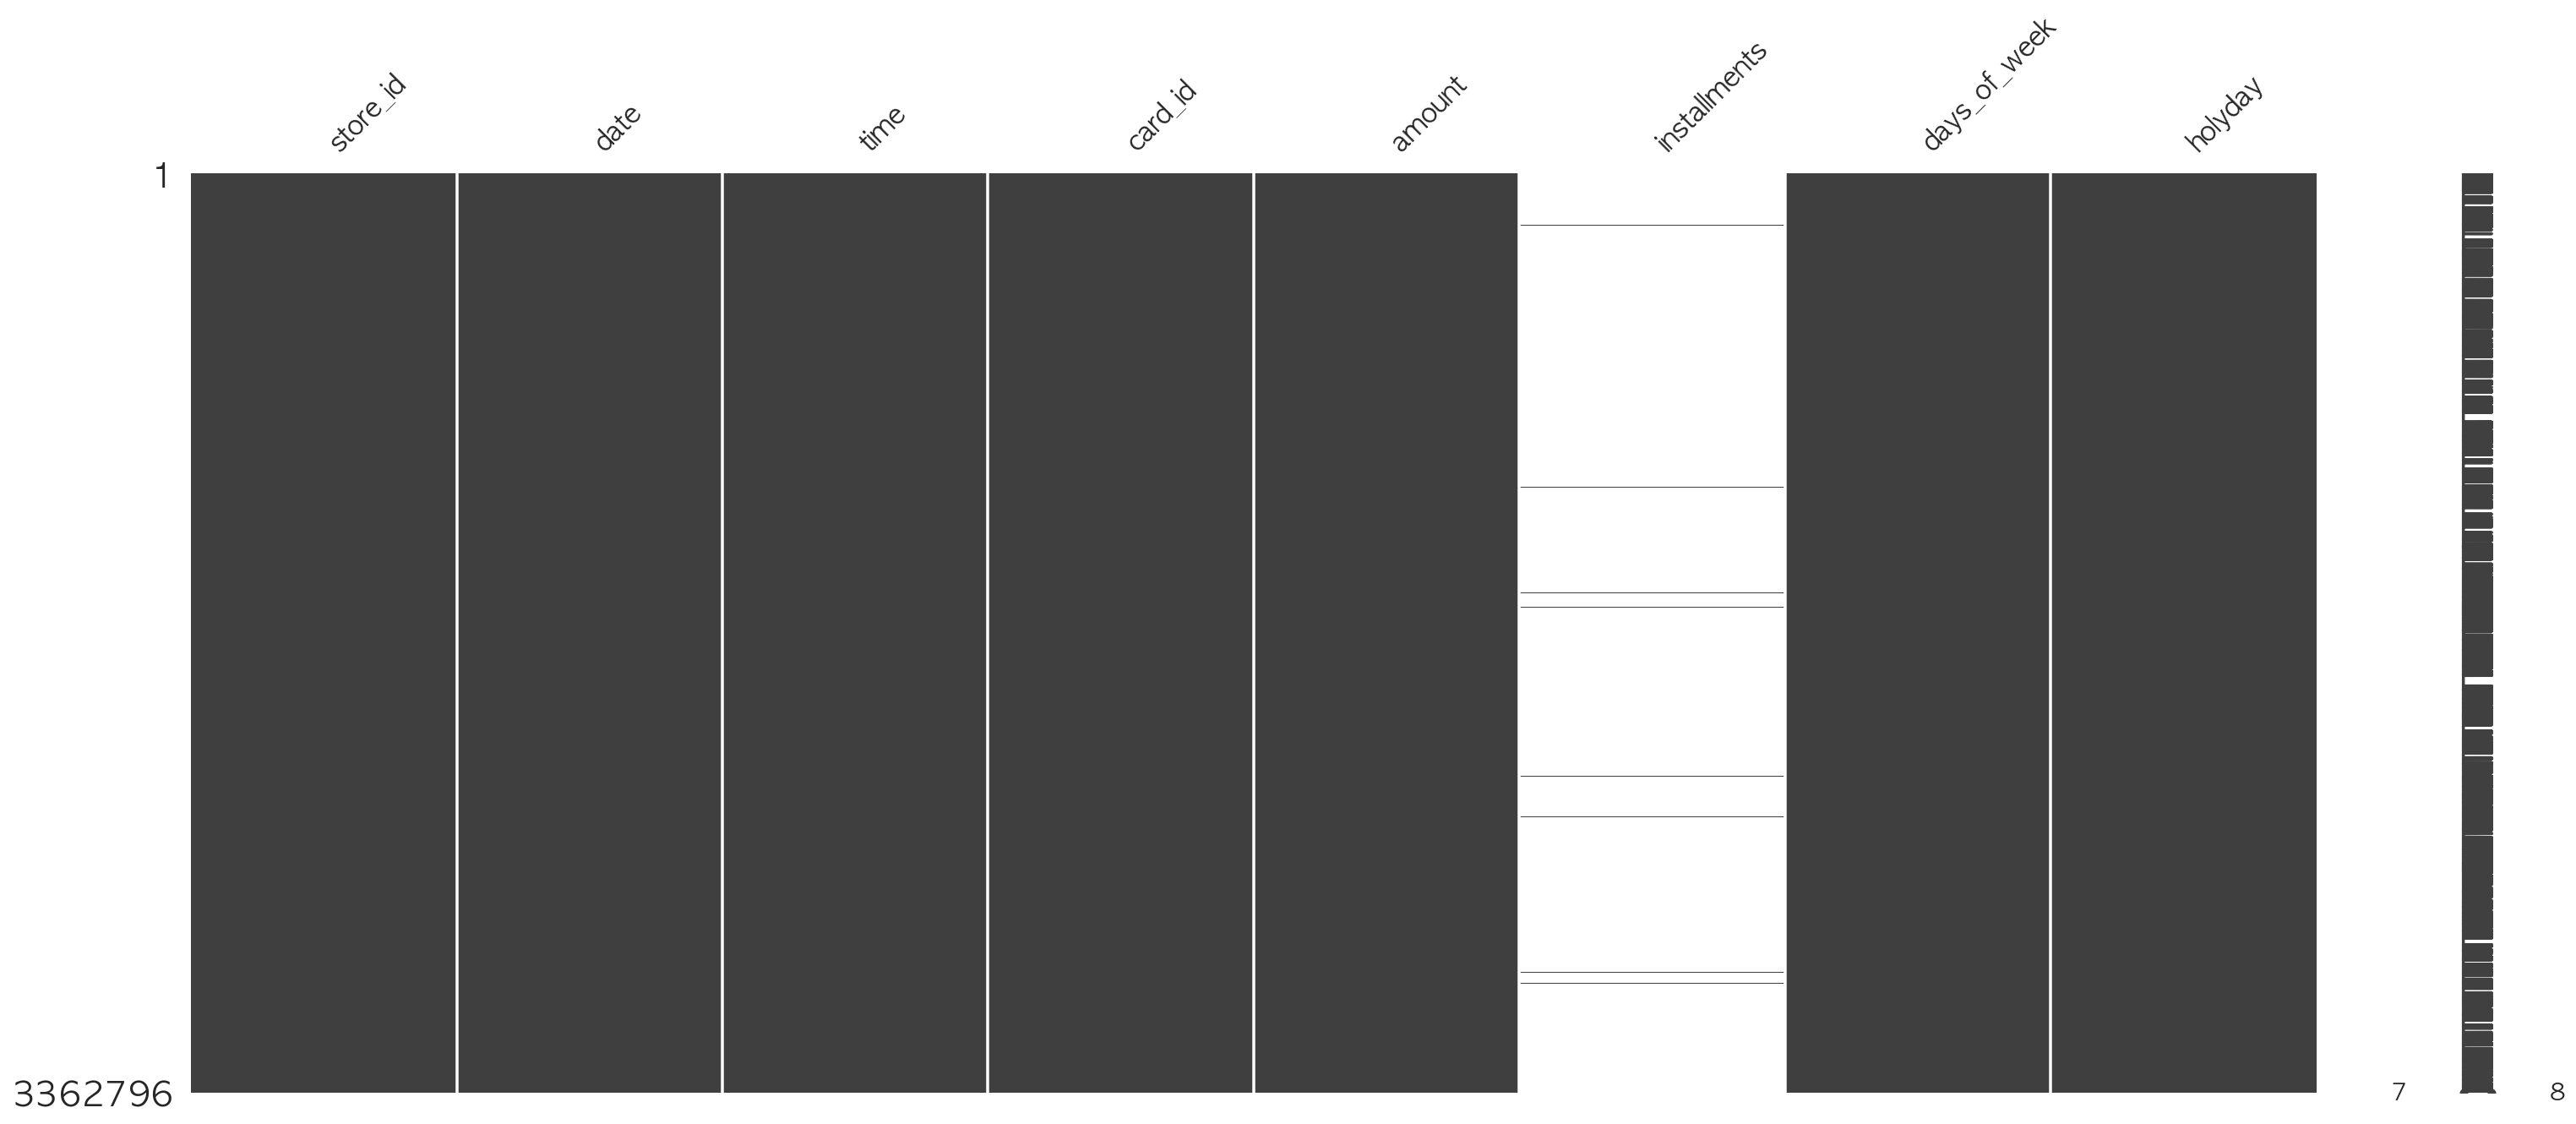

In [81]:
import missingno as msno

msno.matrix(train)
plt.show()

---
- null data 

    - installments 
    

- installments 은 할부값

    - NaN값은 일시불 결제를 뜻함. 
    - NaN = 1로 대체 가능
    
---

In [380]:
train['installments'] = train['installments'].fillna(1)

In [83]:
train.tail()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,1.00,3,0
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,1.00,3,0
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,1.00,6,0
3362794,1799,2018-07-25,18:09:13,57932602d6,300,1.00,2,0
3362795,1799,2018-07-30,10:58:53,42d354807a,325,1.00,0,0


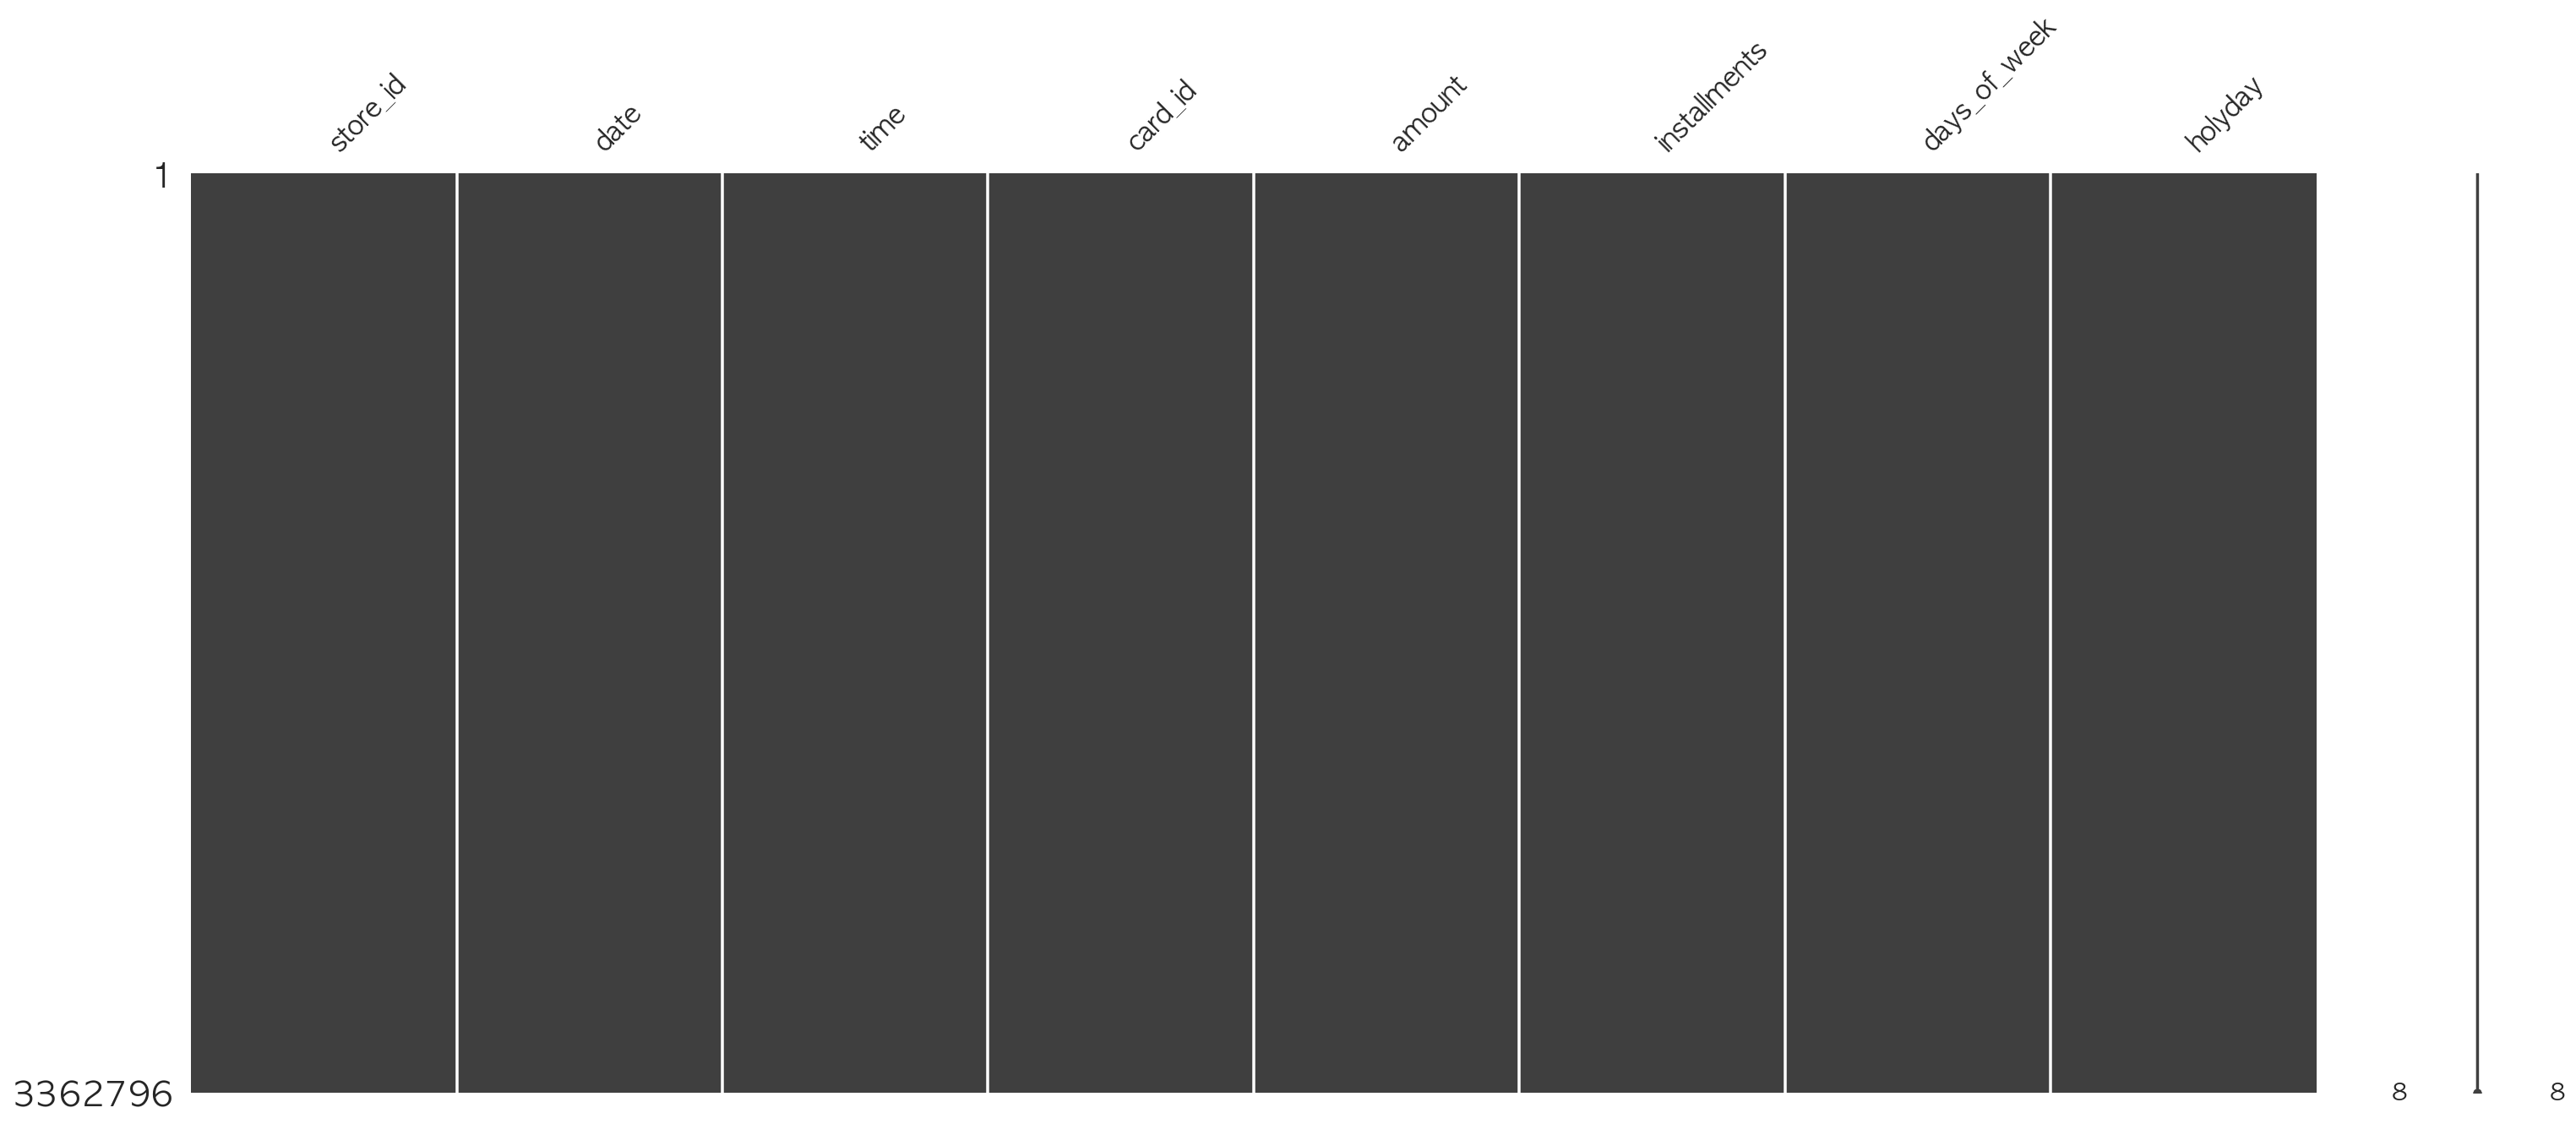

In [84]:
import missingno as msno

msno.matrix(train)
plt.show()

---

#### 데이터 타입 변경

In [381]:
x = list(train.columns)

train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day

train['hour'] = train['time'].apply(lambda x: x[0:2])
train['hour'] = train['hour'].astype('int')

train['weekend'] = train['days_of_week'].apply(lambda x: 1 if x >= 4 else 0)

train['total'] = train['amount'] * train['installments'].astype('int')

train['count'] = train['store_id'].apply(lambda x: 1 if x >= 0 else 0)

In [382]:
train['installments'] = train['installments'].astype(np.int64)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362796 entries, 0 to 3362795
Data columns (total 15 columns):
store_id        int64
date            datetime64[ns]
time            object
card_id         object
amount          int64
installments    int64
days_of_week    int64
holyday         int64
year            int64
month           int64
day             int64
hour            int64
weekend         int64
total           int64
count           int64
dtypes: datetime64[ns](1), int64(12), object(2)
memory usage: 384.8+ MB


In [87]:
train.tail()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year,month,day,hour,weekend,total,count
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,1,3,0,2018,7,19,17,0,600,1
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,1,3,0,2018,7,19,18,0,275,1
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,1,6,0,2018,7,22,14,1,350,1
3362794,1799,2018-07-25,18:09:13,57932602d6,300,1,2,0,2018,7,25,18,0,300,1
3362795,1799,2018-07-30,10:58:53,42d354807a,325,1,0,0,2018,7,30,10,0,325,1


In [61]:
train['count'].count()

3362796

---
#### 상관관계

In [482]:
train.corr()

,store_id,amount,installments,days_of_week,holyday,year,month,day,hour,weekend,total,count
store_id,1.00,0.02,0.00,0.01,0.00,0.01,0.00,-0.00,0.02,0.01,0.01,nan
amount,0.02,1.00,0.18,-0.00,-0.00,-0.01,0.00,0.00,0.01,-0.00,0.68,nan
installments,0.00,0.18,1.00,-0.01,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.44,nan
days_of_week,0.01,-0.00,-0.01,1.00,-0.10,-0.01,0.02,-0.01,-0.02,0.87,-0.00,nan
holyday,0.00,-0.00,-0.00,-0.10,1.00,0.01,-0.02,-0.14,-0.01,-0.08,-0.00,nan
year,0.01,-0.01,-0.00,-0.01,0.01,1.00,-0.60,-0.00,-0.00,-0.00,-0.00,nan
month,0.00,0.00,0.00,0.02,-0.02,-0.60,1.00,0.01,0.00,0.02,0.00,nan
day,-0.00,0.00,0.00,-0.01,-0.14,-0.00,0.01,1.00,0.00,-0.01,0.00,nan
hour,0.02,0.01,-0.00,-0.02,-0.01,-0.00,0.00,0.00,1.00,-0.01,0.00,nan
weekend,0.01,-0.00,-0.00,0.87,-0.08,-0.00,0.02,-0.01,-0.01,1.00,-0.00,nan


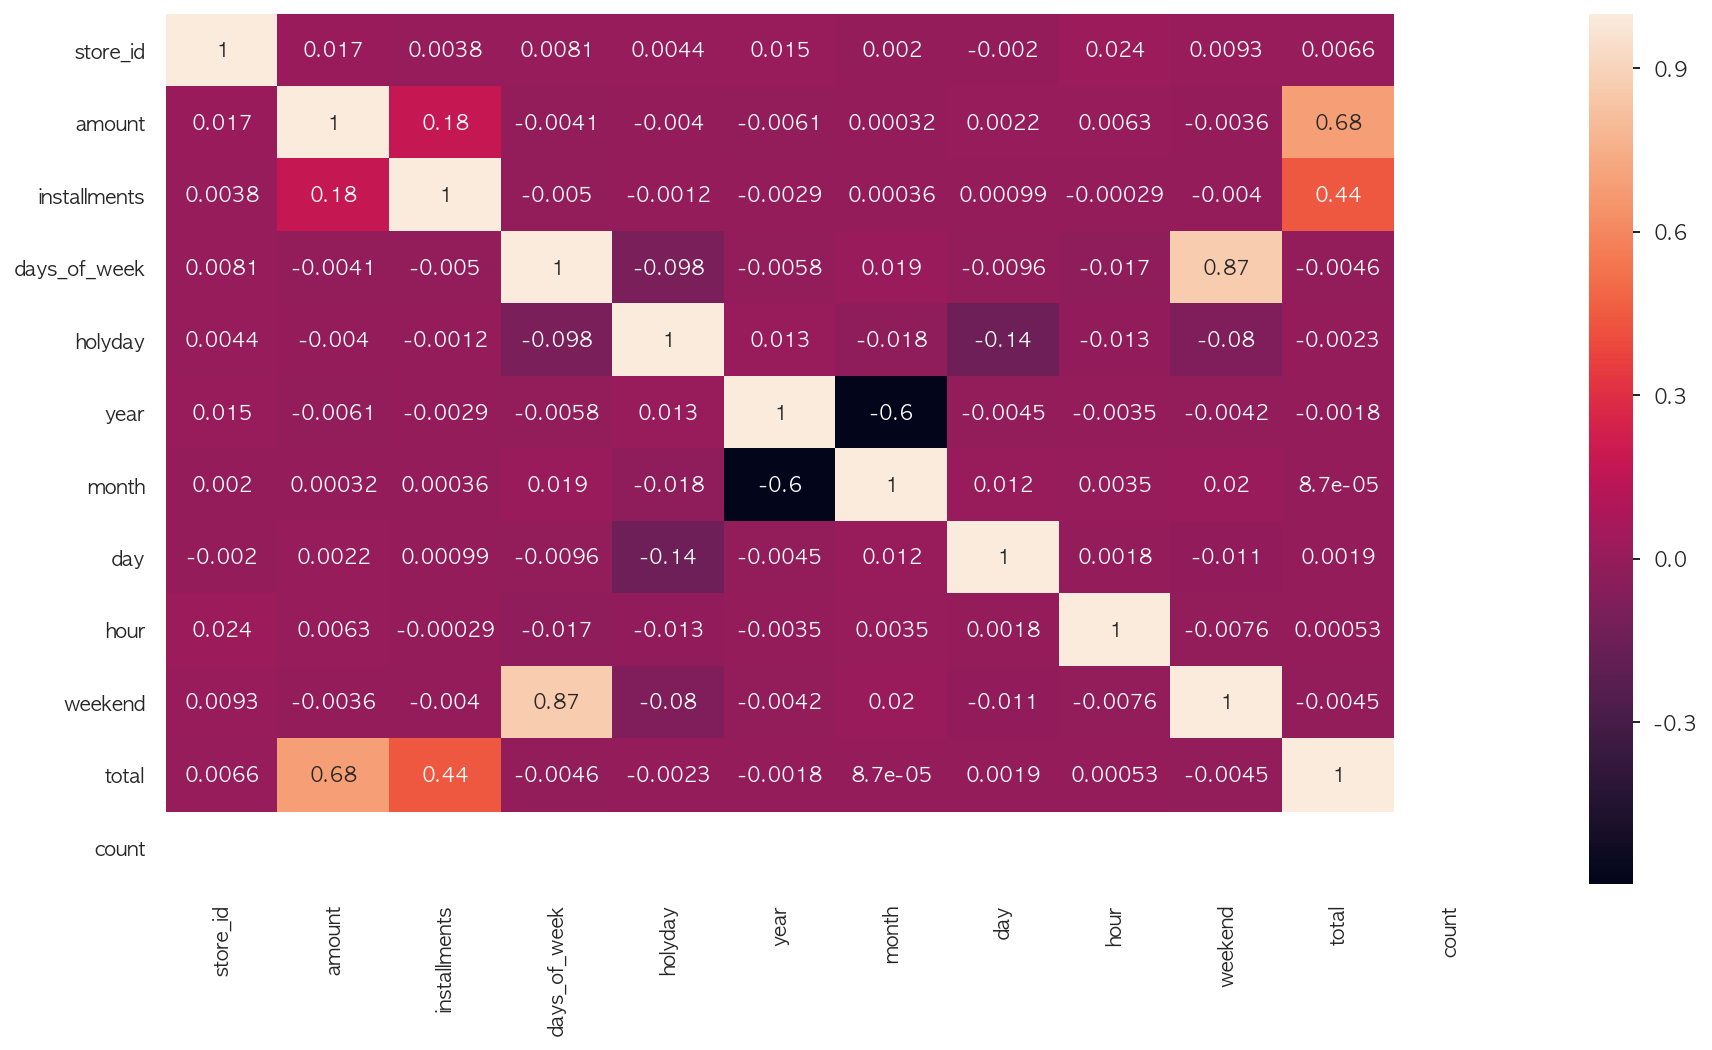

In [483]:
import seaborn as sns
sns.heatmap(train.corr(), annot=True)
plt.show()

--- 
### 가설 1. 저녁 시간대에 카드 결제 금액이 가장 높은 요일은 금요일일 것이다.

---
#### 요일 변수 설정

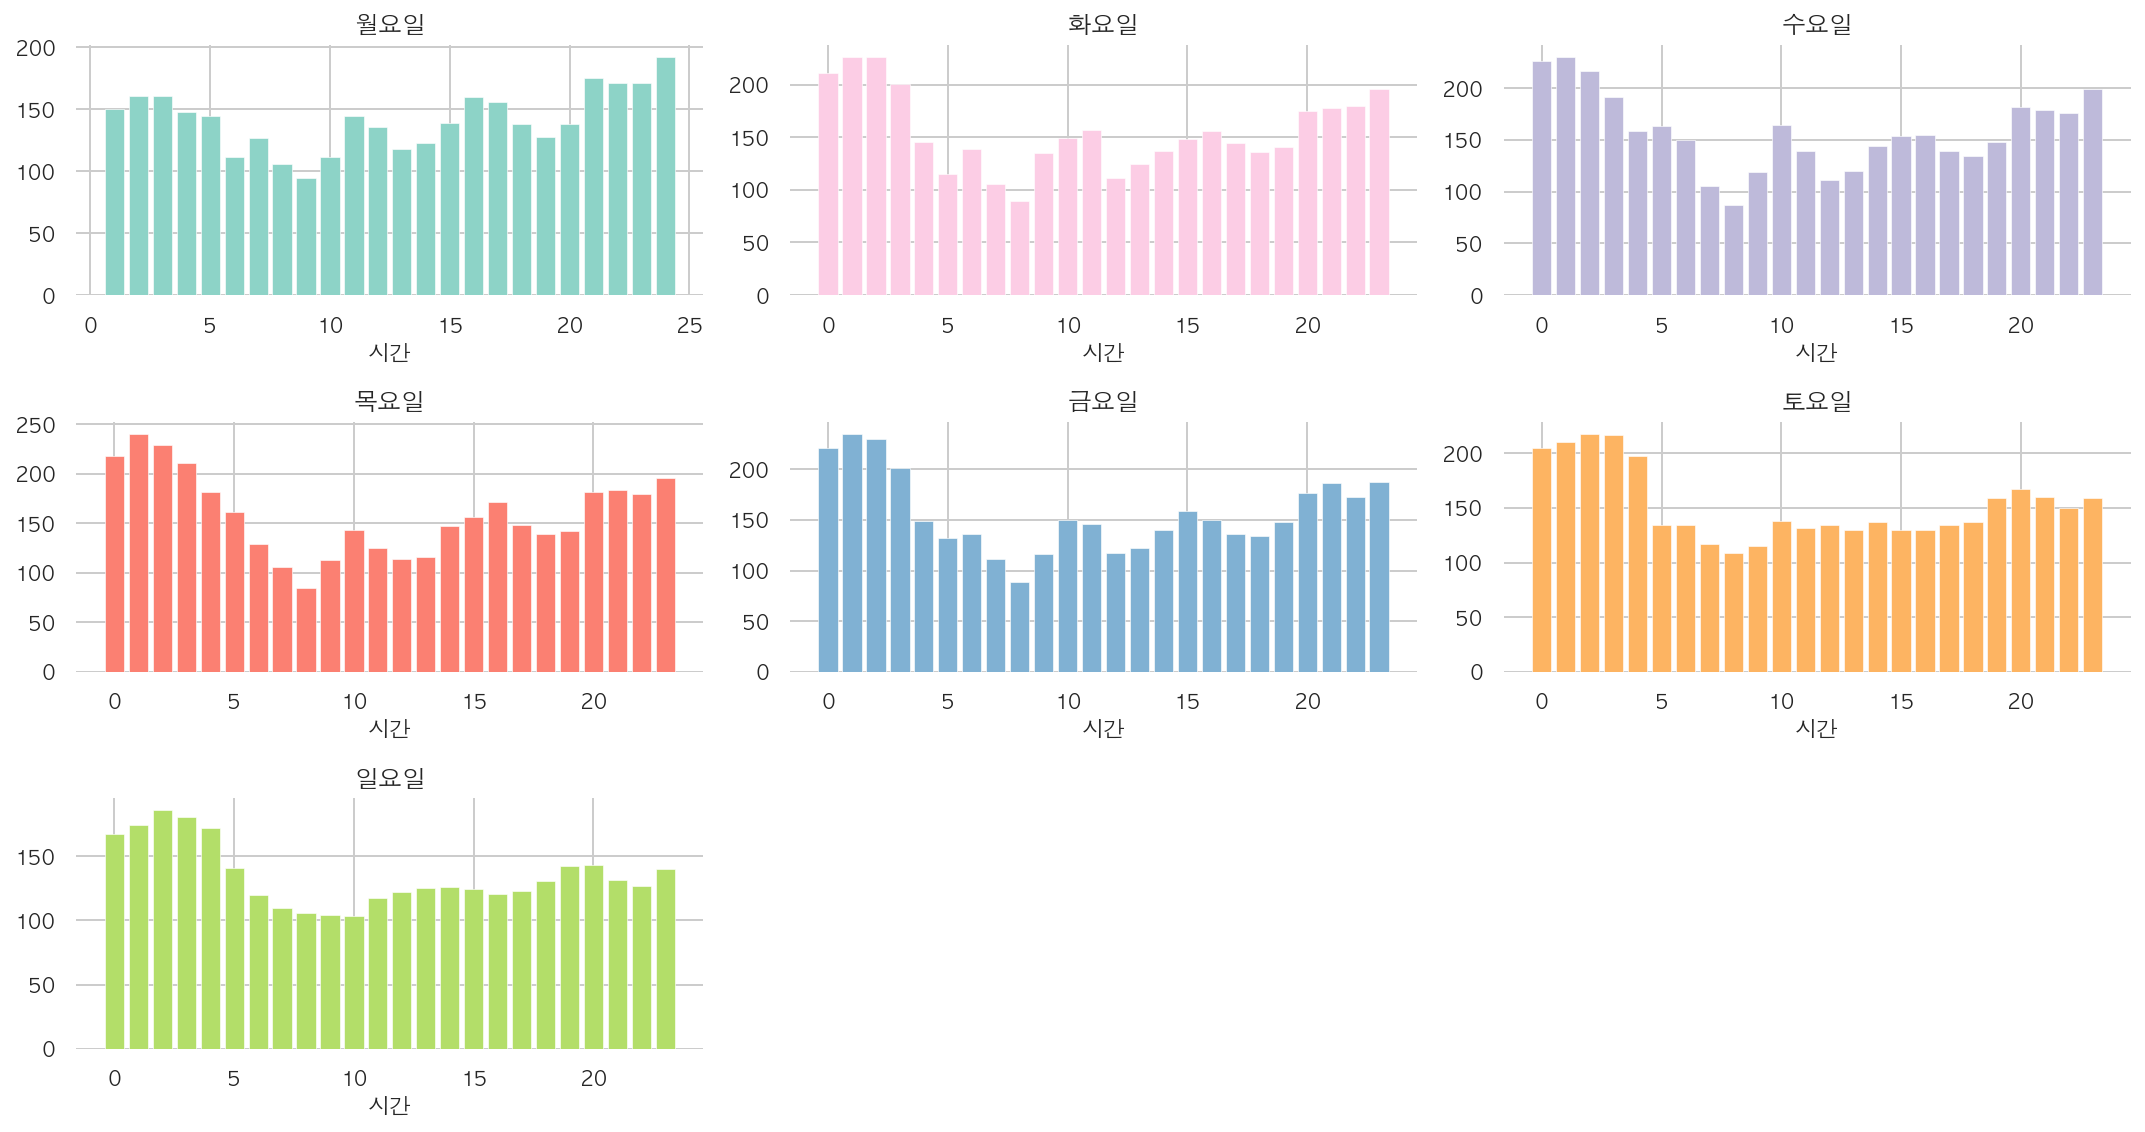

In [420]:
train_m = train[train['days_of_week']==0]
train_t1 = train[train['days_of_week']==1]
train_w = train[train['days_of_week']==2]
train_t2 = train[train['days_of_week']==3]
train_f = train[train['days_of_week']==4]
train_s1 = train[train['days_of_week']==5]
train_s2 = train[train['days_of_week']==6]

cnt_srs_m = train_m.groupby('hour')['amount'].mean()
cnt_srs_t1 = train_t1.groupby('hour')['amount'].mean()
cnt_srs_w = train_w.groupby('hour')['amount'].mean()
cnt_srs_t2 = train_t2.groupby('hour')['amount'].mean()
cnt_srs_f = train_f.groupby('hour')['amount'].mean()
cnt_srs_s1 = train_s1.groupby('hour')['amount'].mean()
cnt_srs_s2 = train_s2.groupby('hour')['amount'].mean()

plt.subplot(3,3,1)
m_amount = list(cnt_srs_m)
x = np.arange(1,25)
plt.bar(x, m_amount, color=[0.55294118, 0.82745098, 0.78039216, 1.        ])
plt.title("월요일")
plt.xlabel("시간")

plt.subplot(3,3,2)
t1_amount = list(cnt_srs_t1)
x = np.arange(0,24)
plt.bar(x, t1_amount, color=[0.98823529, 0.80392157, 0.89803922, 1.        ])
plt.title("화요일")
plt.xlabel("시간")

plt.subplot(3,3,3)
w_amount = list(cnt_srs_w)
x = np.arange(0,24)
plt.bar(x, w_amount, color=[0.74509804, 0.72941176, 0.85490196, 1.        ])
plt.title("수요일")
plt.xlabel("시간")

plt.subplot(3,3,4)
t2_amount = list(cnt_srs_t2)
x = np.arange(0,24)
plt.bar(x, t2_amount, color=[0.98431373, 0.50196078, 0.44705882, 1.        ])
plt.title("목요일")
plt.xlabel("시간")

plt.subplot(3,3,5)
f_amount = list(cnt_srs_f)
x = np.arange(0,24)
plt.bar(x, f_amount, color=[0.50196078, 0.69411765, 0.82745098, 1.        ])
plt.title("금요일")
plt.xlabel("시간")

plt.subplot(3,3,6)
s1_amount = list(cnt_srs_s1)
x = np.arange(0,24)
plt.bar(x, s1_amount, color=[0.99215686, 0.70588235, 0.38431373, 1.        ])
plt.title("토요일")
plt.xlabel("시간")

plt.subplot(3,3,7)
s2_amount = list(cnt_srs_s2)
x = np.arange(0,24)
plt.bar(x, s2_amount, color=[0.70196078, 0.87058824, 0.41176471, 1.        ])
plt.title("일요일")
plt.xlabel("시간")

plt.tight_layout()
plt.show()

 - 월요일 제외한 새벽 1-4시 사이에 결제 금액이 가장 높다. 
 - 월요일은 저녁 9-12시 사이에 결제 금액이 높게 나타나는 것을 볼 수 있다. 

In [423]:
# 저녁시간대 확대 (20 ~ 04시)

mid_m = list(cnt_srs_m[20:]) + list(cnt_srs_m[1:4])
mid_m = np.array(mid_m)
m = np.mean(mid_m)

mid_t1 = list(cnt_srs_t1[20:]) + list(cnt_srs_t1[1:4])
mid_t1 = np.array(mid_t1)
t1 = np.mean(mid_t1)

mid_w = list(cnt_srs_w[20:]) + list(cnt_srs_w[1:4])
mid_w = np.array(mid_w)
w = np.mean(mid_w)

mid_t2 = list(cnt_srs_t2[20:]) + list(cnt_srs_t2[1:4])
mid_t2 = np.array(mid_t2)
t2 = np.mean(mid_t2)

mid_f = list(cnt_srs_f[20:]) + list(cnt_srs_f[1:4])
mid_f = np.array(mid_f)
f = np.mean(mid_f)

mid_s1 = list(cnt_srs_s1[20:]) + list(cnt_srs_s1[1:4])
mid_s1 = np.array(mid_s1)
s1 = np.mean(mid_s1)

mid_s2 = list(cnt_srs_s2[20:]) + list(cnt_srs_s2[1:4])
mid_s2 = np.array(mid_s2)
s2 = np.mean(mid_s2)

(120, 210)

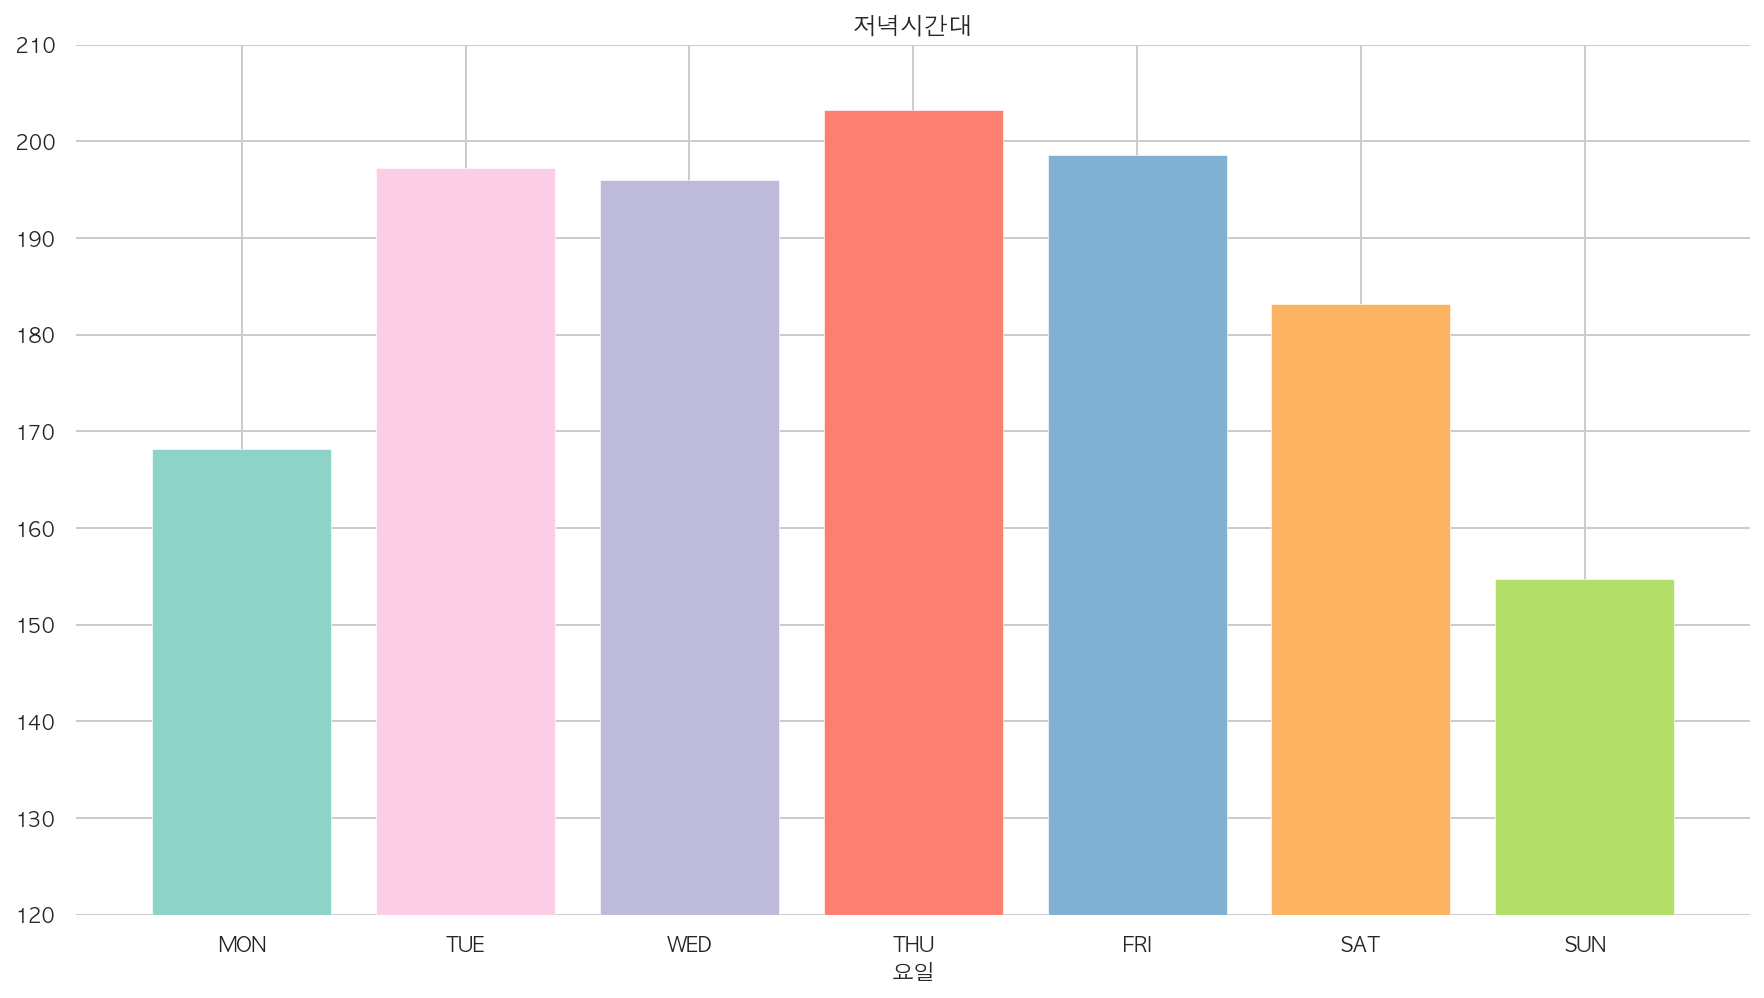

In [422]:
midnight_amount = list([m, t1, w, t2, f, s1, s2])
x = list(["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"])
plt.bar(x, midnight_amount, color=[[0.55294118, 0.82745098, 0.78039216, 1.        ],
       [0.98823529, 0.80392157, 0.89803922, 1.        ],
       [0.74509804, 0.72941176, 0.85490196, 1.        ],
       [0.98431373, 0.50196078, 0.44705882, 1.        ],
       [0.50196078, 0.69411765, 0.82745098, 1.        ],
       [0.99215686, 0.70588235, 0.38431373, 1.        ],
       [0.70196078, 0.87058824, 0.41176471, 1.        ]])
plt.title("저녁시간대")
plt.xlabel("요일")
plt.ylim(120, 210)

 - 저녁시간대를 확인해봤더니 금요일보다는 목요일 저녁시간에 결제금액이 높은 것으로 나타났다.
     
     - 요즘은 불금보다는 불목이 대세인 듯 하다. 
     - 금요일의 결제금액이 높을 것이다라는 가설은 오류. 
     - 기각.

---
### 가설 2. 평일 오후 2~3시에 할부 결제 건이 높을 것이다.
---

In [549]:
ins = train["installments"] !=1

 - 할부 결제를 한 데이터를 확인하기 위함

In [554]:
df = train[ins].groupby(train.days_of_week)

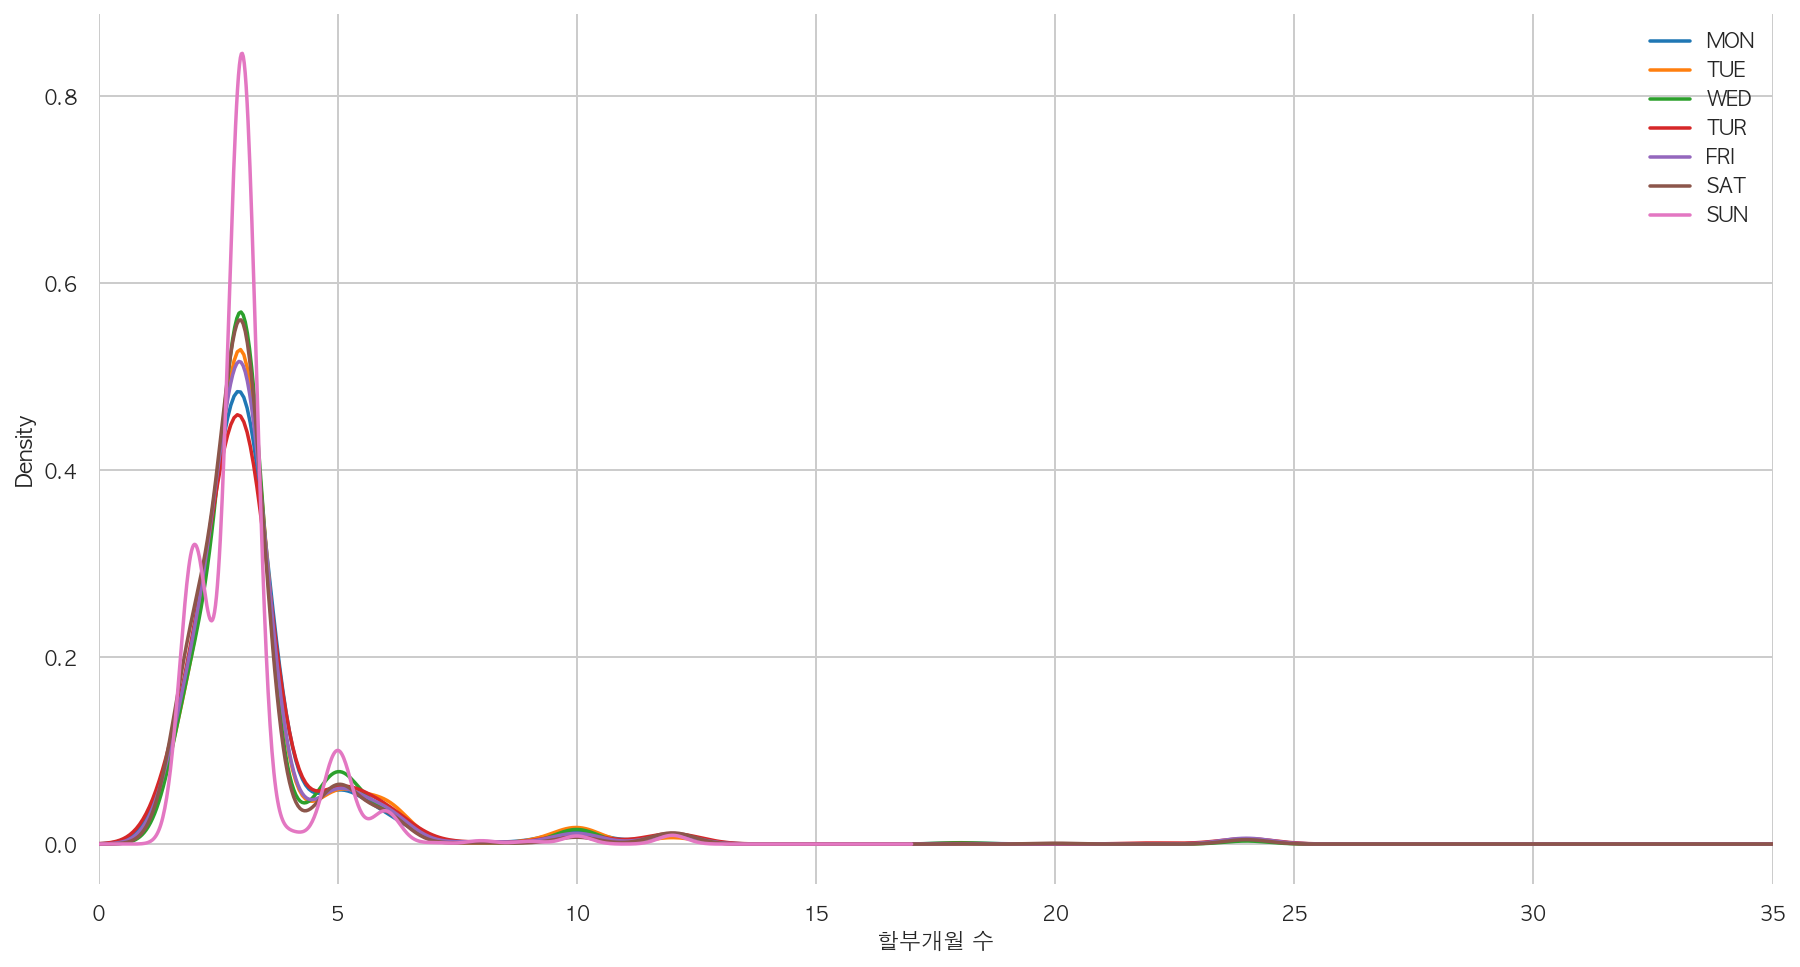

In [552]:
df.installments.plot.kde()
plt.xlim(0, 35)
plt.xlabel("할부개월 수")
plt.legend(["MON", "TUE", "WED", "TUR", "FRI","SAT", "SUN"])

 - 할부개월수에 대한 결제건을 요일별로 나타낸 그래프를 보면, 
 - 일요일에 할부 결제를 많이하는 것을 볼 수 있다. 

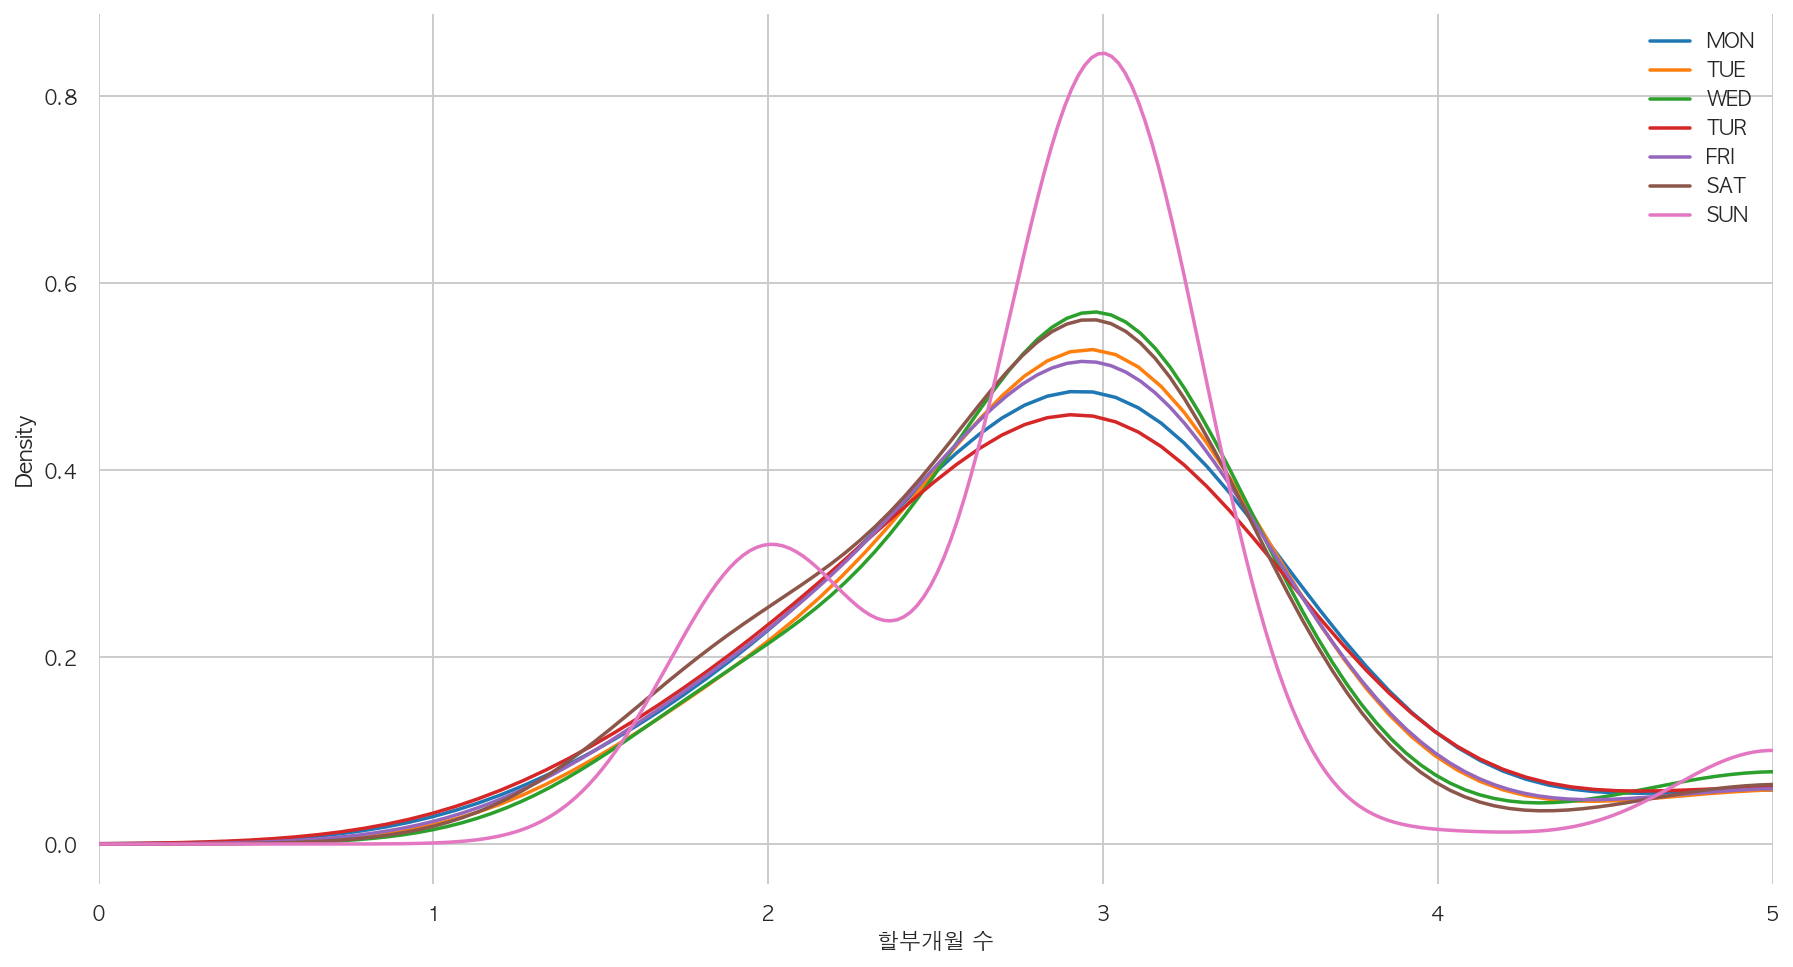

In [555]:
df.installments.plot.kde()
plt.xlim(0, 5)
plt.xlabel("할부개월 수")
plt.legend(["MON", "TUE", "WED", "TUR", "FRI","SAT", "SUN"])

 - 1-5개월까지의 할부개월수를 확인할 결과, 
 - 3개월할부가 가장 많았고, 일요일에 할부를 많이 쓰는 것으로 볼 수 있다. 

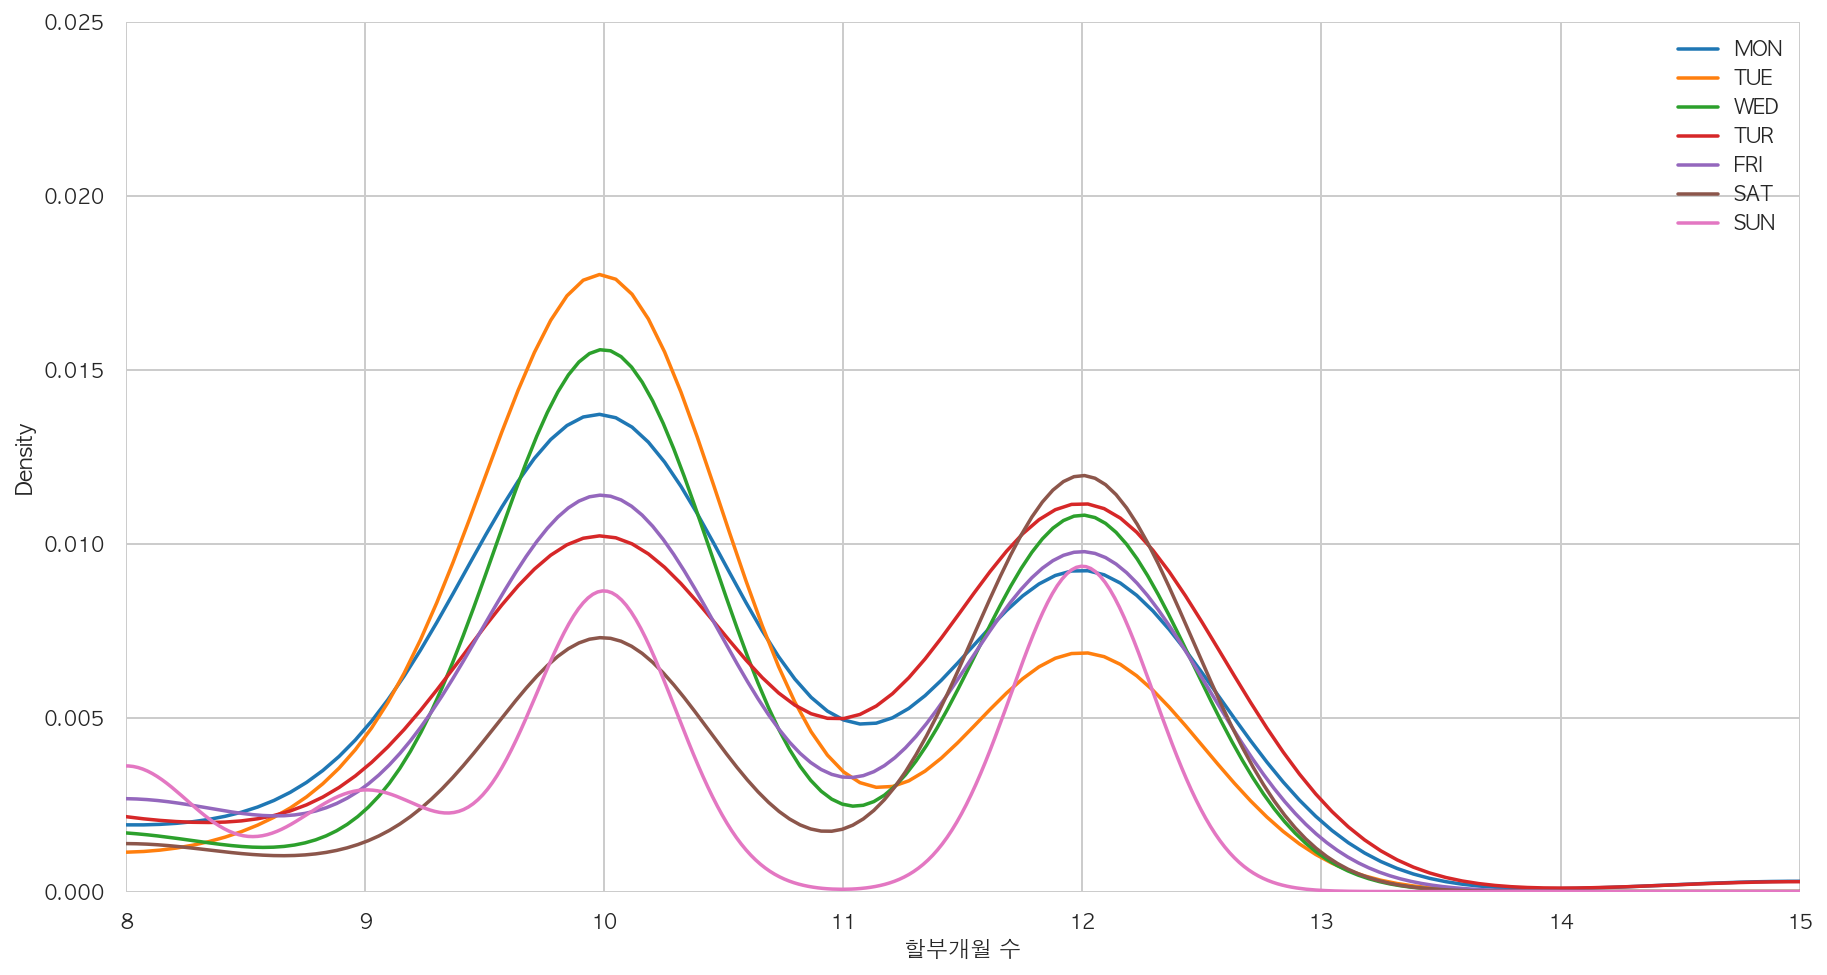

In [556]:
df.installments.plot.kde()
plt.xlim(8, 15)
plt.ylim(0, 0.025)
plt.xlabel("할부개월 수")
plt.legend(["MON", "TUE", "WED", "TUR", "FRI","SAT", "SUN"])

 - 8-15개월까지를 확대한 결과, 10개월 할부가 가장 많았고, 
 - 주말보다는 평일에 결제한 건이 높아진 것을 볼 수 있었다. 

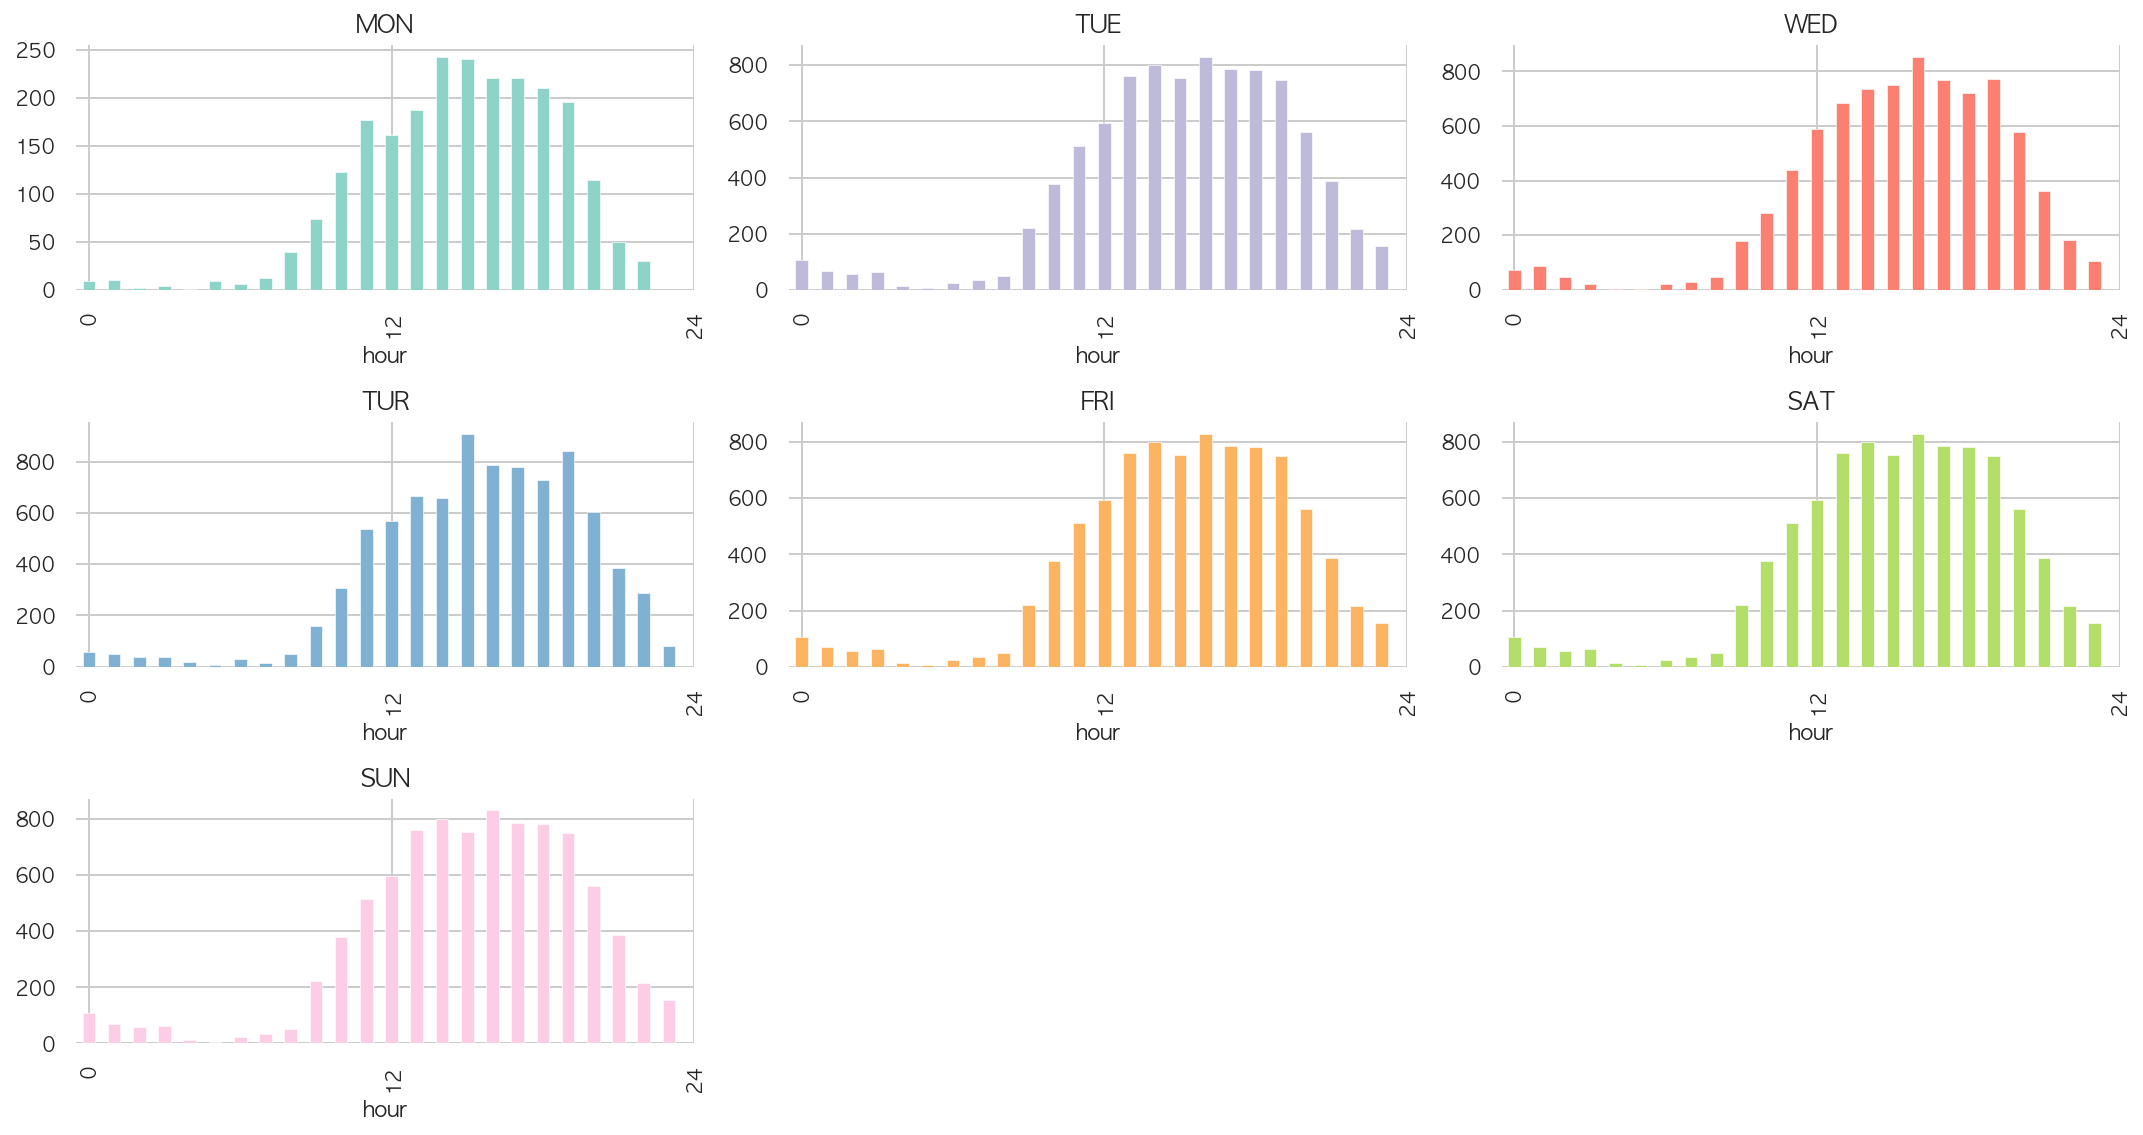

In [424]:
ins = train['installments'] !=1

plt.subplot(331)
ins_m = train[ins]["days_of_week"] == 0
ins_m1 = train[ins][ins_m]
m_hour = ins_m1.groupby('hour')['count']
m_hour.sum().plot.bar(color = [0.55294118, 0.82745098, 0.78039216, 1.        ])
plt.xticks([0, 12, 24],[0,12,24])
plt.title("MON")

plt.subplot(332)
ins_t = train[ins]["days_of_week"] == 1
ins_t1 = train[ins][ins_t]
m_hour = ins_t1.groupby('hour')['installments']
m_hour.sum().plot.bar(color = [0.74509804, 0.72941176, 0.85490196, 1.        ])
plt.xticks([0, 12, 24],[0,12,24])
plt.title("TUE")

plt.subplot(333)
ins_w = train[ins]["days_of_week"] == 2
ins_w1 = train[ins][ins_w]
m_hour = ins_w1.groupby('hour')['installments']
m_hour.sum().plot.bar(color = [0.98431373, 0.50196078, 0.44705882, 1.        ])
plt.xticks([0, 12, 24],[0,12,24])
plt.title("WED")

plt.subplot(334)
ins_h = train[ins]["days_of_week"] == 3
ins_h1 = train[ins][ins_h]
m_hour = ins_h1.groupby('hour')['installments']
m_hour.sum().plot.bar(color = [[0.50196078, 0.69411765, 0.82745098, 1.        ]])
plt.xticks([0, 12, 24],[0,12,24])
plt.title("TUR")

plt.subplot(335)
ins_f = train[ins]["days_of_week"] == 4
ins_f1 = train[ins][ins_f]
m_hour = ins_t1.groupby('hour')['installments']
m_hour.sum().plot.bar(color = [0.99215686, 0.70588235, 0.38431373, 1.        ])
plt.xticks([0, 12, 24],[0,12,24])
plt.title("FRI")

plt.subplot(336)
ins_s = train[ins]["days_of_week"] == 5
ins_s1 = train[ins][ins_s]
m_hour = ins_t1.groupby('hour')['installments']
m_hour.sum().plot.bar(color = [0.70196078, 0.87058824, 0.41176471, 1.        ])
plt.xticks([0, 12, 24],[0,12,24])
plt.title("SAT")

plt.subplot(337)
ins_n = train[ins]["days_of_week"] == 6
ins_n = train[ins][ins_n]
m_hour = ins_t1.groupby('hour')['installments']
m_hour.sum().plot.bar(color = [0.98823529, 0.80392157, 0.89803922, 1.        ])
plt.xticks([0, 12, 24],[0,12,24])
plt.title("SUN")

plt.tight_layout()
plt.show()

 - 시간대별 할부 이용 건수를 확인해본결과 2-4시 사이에 많이 이루어진 것을 알 수 있었다. 
 - 직장인들이 점심시간 이후에 쇼핑을 하거나, 주부들이 쇼핑하는 시간이 2-4시인 것으로 예측해볼 수 있다.

In [452]:
train1 = pd.read_csv("./Dataset/1st_Competition_data/train.csv")
train1['date'] = pd.to_datetime(train['date'])
train1['year'] = train['date'].dt.year
train1['month'] = train['date'].dt.month
train1['day'] = train['date'].dt.day

train1['hour'] = train['time'].apply(lambda x: x[0:2])
train1['hour'] = train['hour'].astype('int')
train1.dropna(axis=0, how="any", inplace=True)
train1['count'] = 1
train1.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,year,month,day,hour,count
152,0,2016-12-21,10:48:04,65d5e33f69,445,3.00,2,0,2016,12,21,10,1
155,0,2016-12-21,11:16:17,65d5e33f69,-445,3.00,2,0,2016,12,21,11,1
206,0,2016-12-21,14:26:24,4a8e737d2c,277,2.00,2,0,2016,12,21,14,1
311,0,2016-12-21,22:17:30,3f59e8684b,375,3.00,2,0,2016,12,21,22,1
651,0,2016-12-24,11:59:37,583d5dd51c,408,3.00,5,0,2016,12,24,11,1


In [453]:
train_size = train1.pivot_table(index="hour", columns="days_of_week", aggfunc="size")

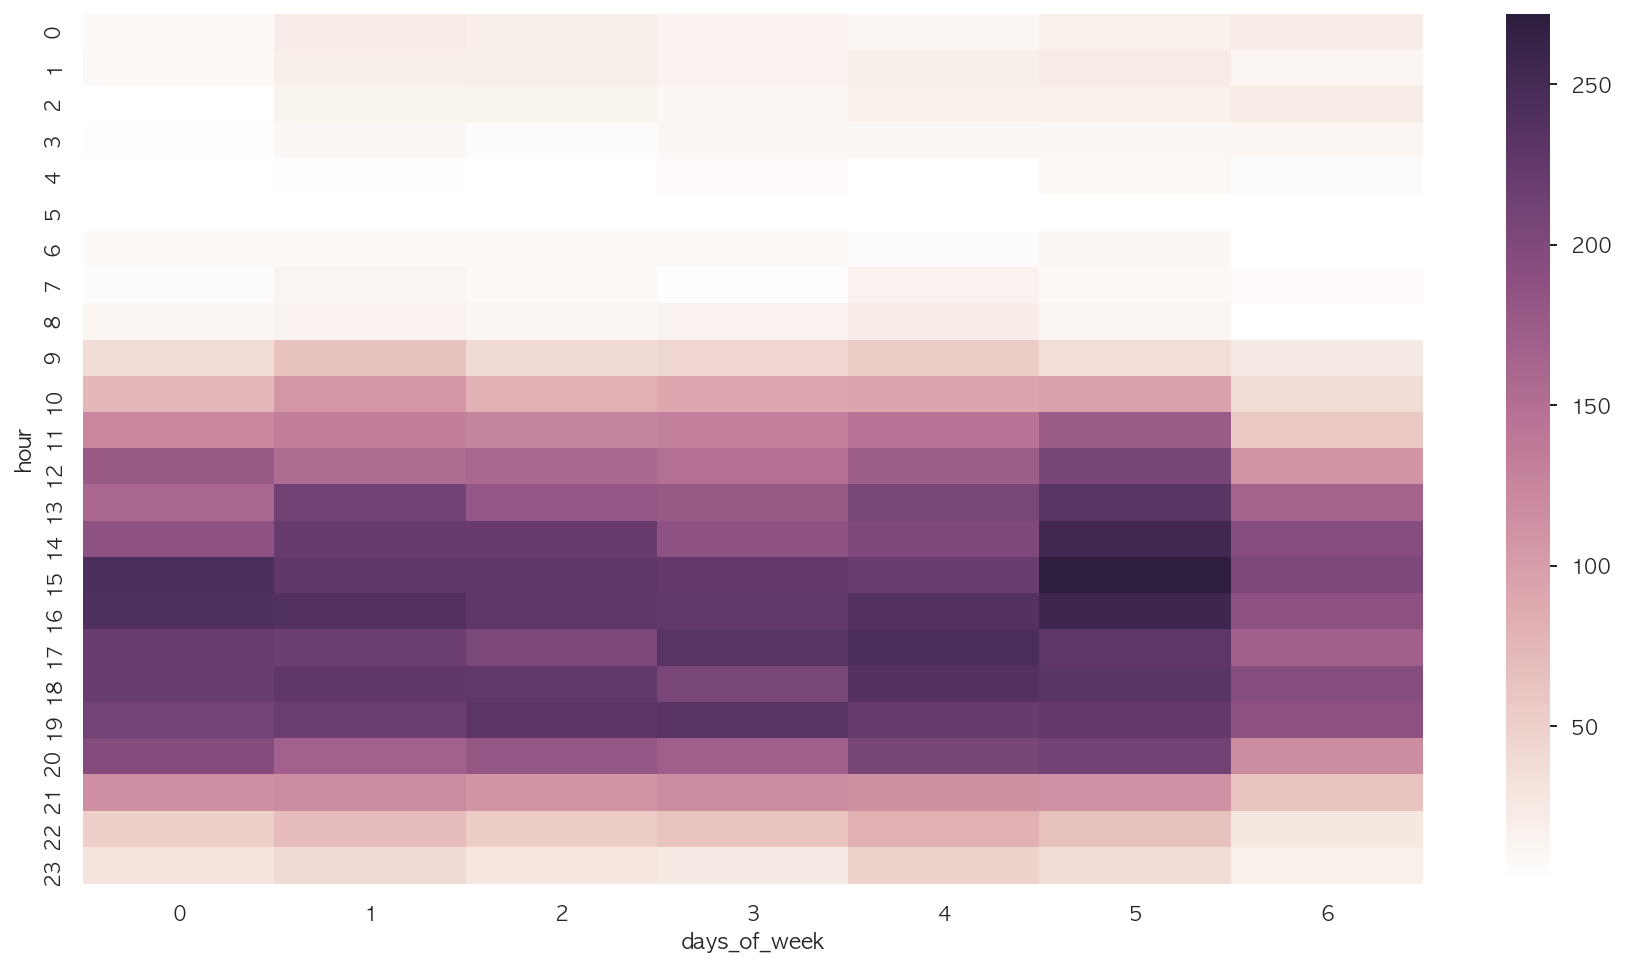

In [454]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(train_size, cmap = cmap )

- 토요일에 2-4시 사이에 할부건수가 많아지는 것을 볼 수 있었다. 
    
    - 평일보다는 토요일 2-4시 사이에 할부 결제 건이 많은 것을 볼 수 있으므로, 
    - 가설2는 기각.

---
### 가설 3

#### 1. 공휴일의 결제금액이 높을 것이다. 
#### 2. 공휴일의 결제 건수가 많을 것이다. 

In [401]:
df_week = train[train['weekend'] == 0]
df_weekend = train[train['weekend'] == 1]
df_holy = train[train['holyday'] == 1]
df_daily = train[train['holyday'] == 0]

df = train.pivot_table("amount",['year','month'],'days_of_week')

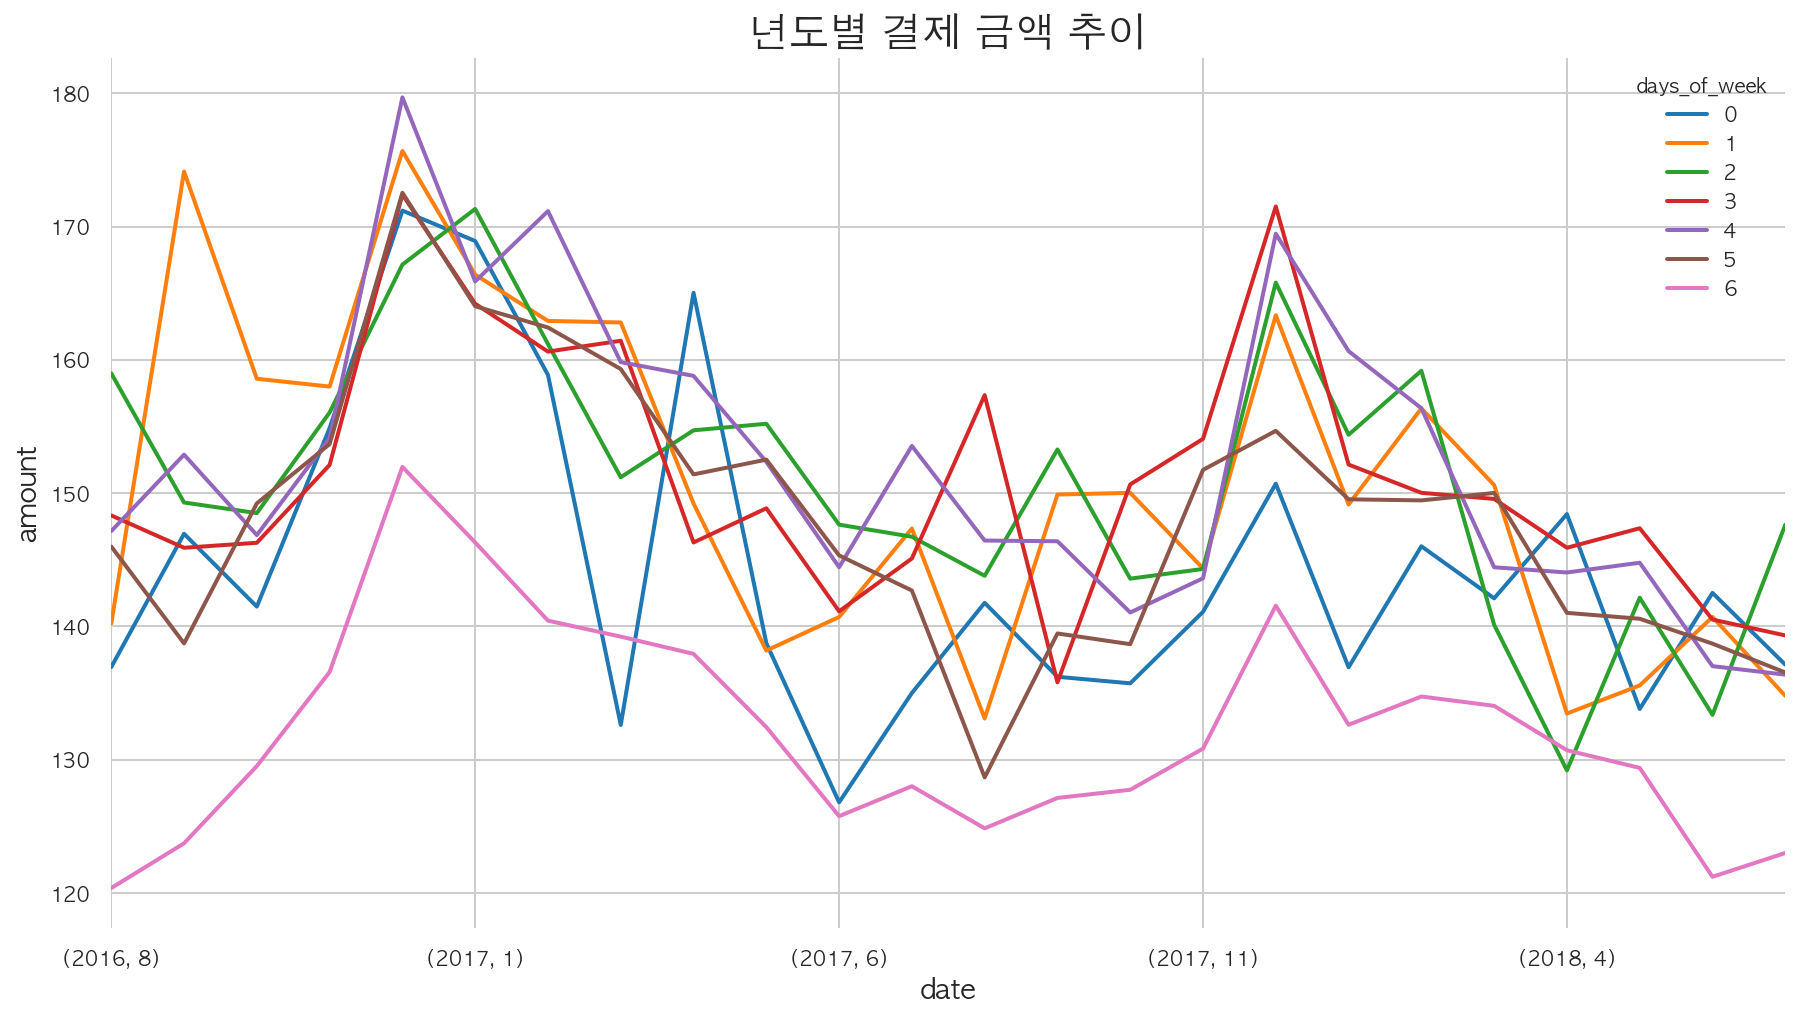

In [442]:
df.plot(linewidth = 2)
plt.xlabel('date',fontsize = 14)
plt.ylabel("amount",fontsize = 14)
plt.title("년도별 결제 금액 추이",fontsize = 20)
plt.show()

 - 지난 3년간의 수치를 볼 때, 급격하게 떨어지는 구간이 있는 것으로 봐서, 휴일에 결제 금액이 급락하는 것으로 예측해볼 수 있을 것이다. 
 
 - 또한 주말의 거래금액 비중에 높지 않은 것으로 보여진다. 
 
 - 2017년 말부터 2018년 초까지 상승세를 보이지만 이후 점점 하락세를 나타내고 있는 것으로 보아 경기 침체를 예측해볼 수 있을 것 같다. 
      
      - 사드로 인한 수출급감으로 인해, 국내에 불황이 일어나면서 소비침체로 이어진 것으로 보인다.

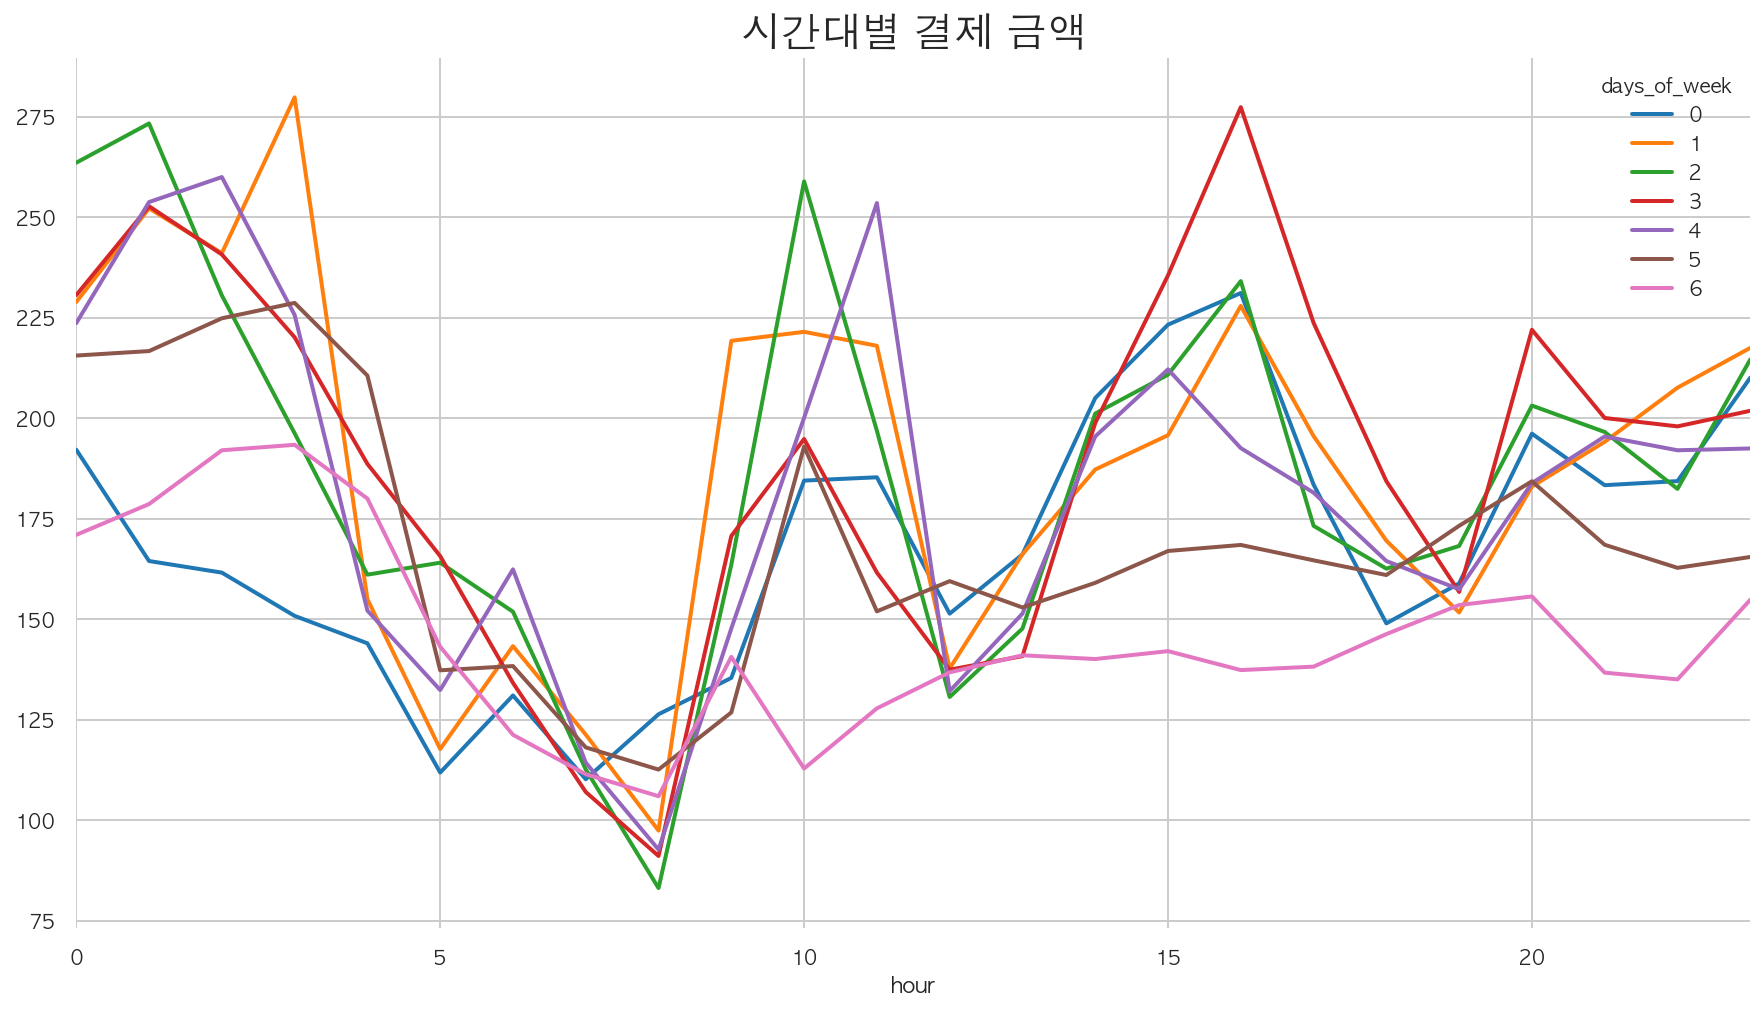

In [486]:
dt = train.pivot_table('total','hour','days_of_week')
dt.plot(linewidth = 2)
plt.title("시간대별 결제 금액",fontsize = 20)

plt.show()

 - 주중 거래금액을 시간별로 나타냈을 때, 주말을 제외하고는 거의 비슷한 양상을 보이고 있다. 
 
 - 오전 10시, 오후 15~16시 사이 거래금액 증가는 주부들의 쇼핑이나 직장인들의 티타임 등이 있을 것이라고 예측할 수 있을 것 같다. 
 
 - 오후 8시 이후부터 거래금액이 서서히 증가하는 것을 볼 수 있는데, 이는 퇴근 후 이루어지는 저녁 식사 등이 있을 수 있고 새벽에 거래금액이 대폭 상승하는 이유는 회식, 술자리 등으로 인해 큰 금액이 결제되는 것을 이유로 볼 수 있을 것 같다. 

In [490]:
len(df_week)

1856516

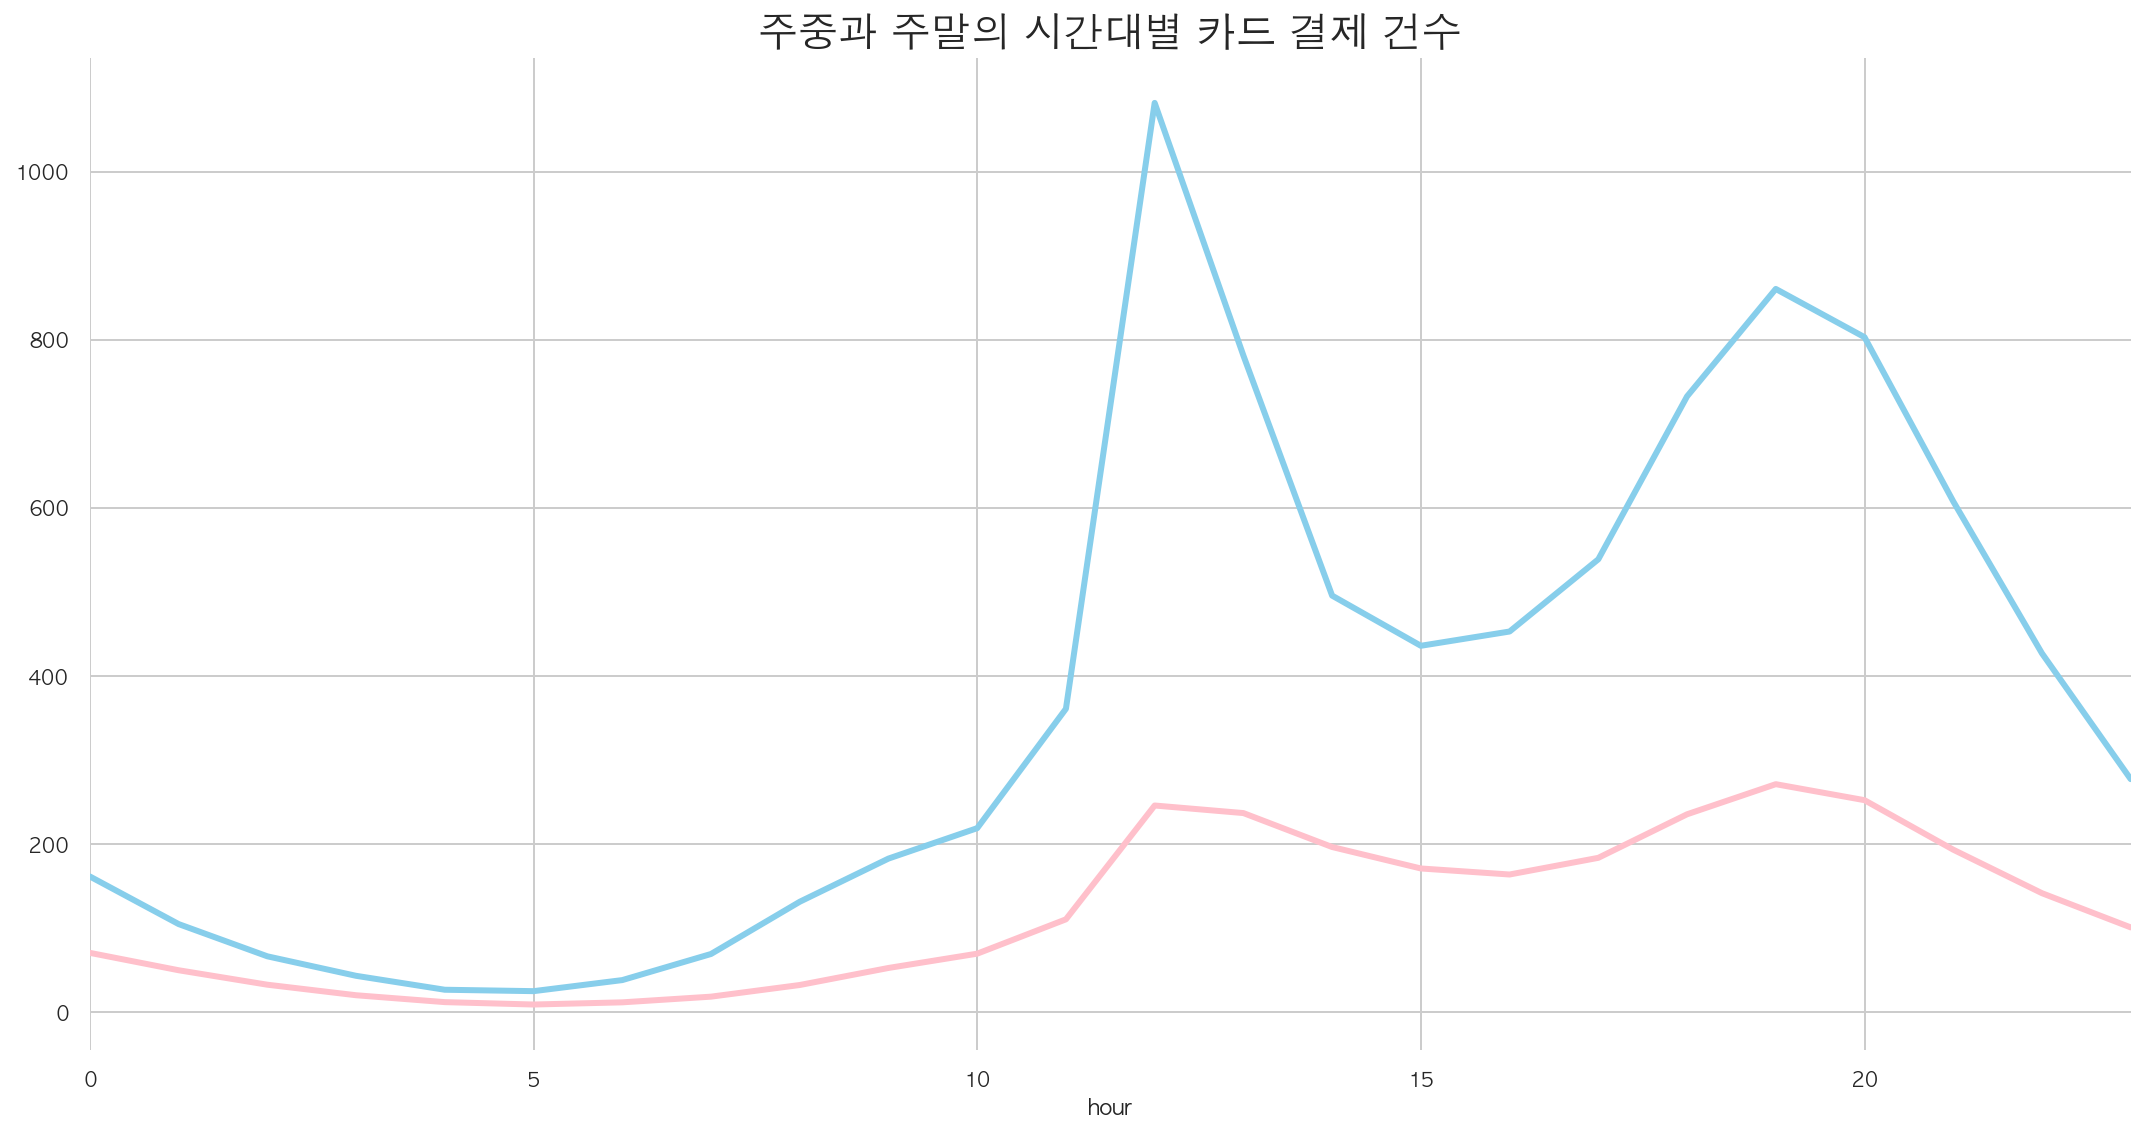

In [491]:
df11 = df_weekend.groupby('hour')['count'].sum() / 522
df12 = df_week.groupby('hour')['count'].sum() / 208
df11.plot(linewidth = 3, color = 'pink')
df12.plot(linewidth = 3, color = 'skyblue')
plt.title("주중과 주말의 시간대별 카드 결제 건수",fontsize = 20)

plt.tight_layout()
plt.show()

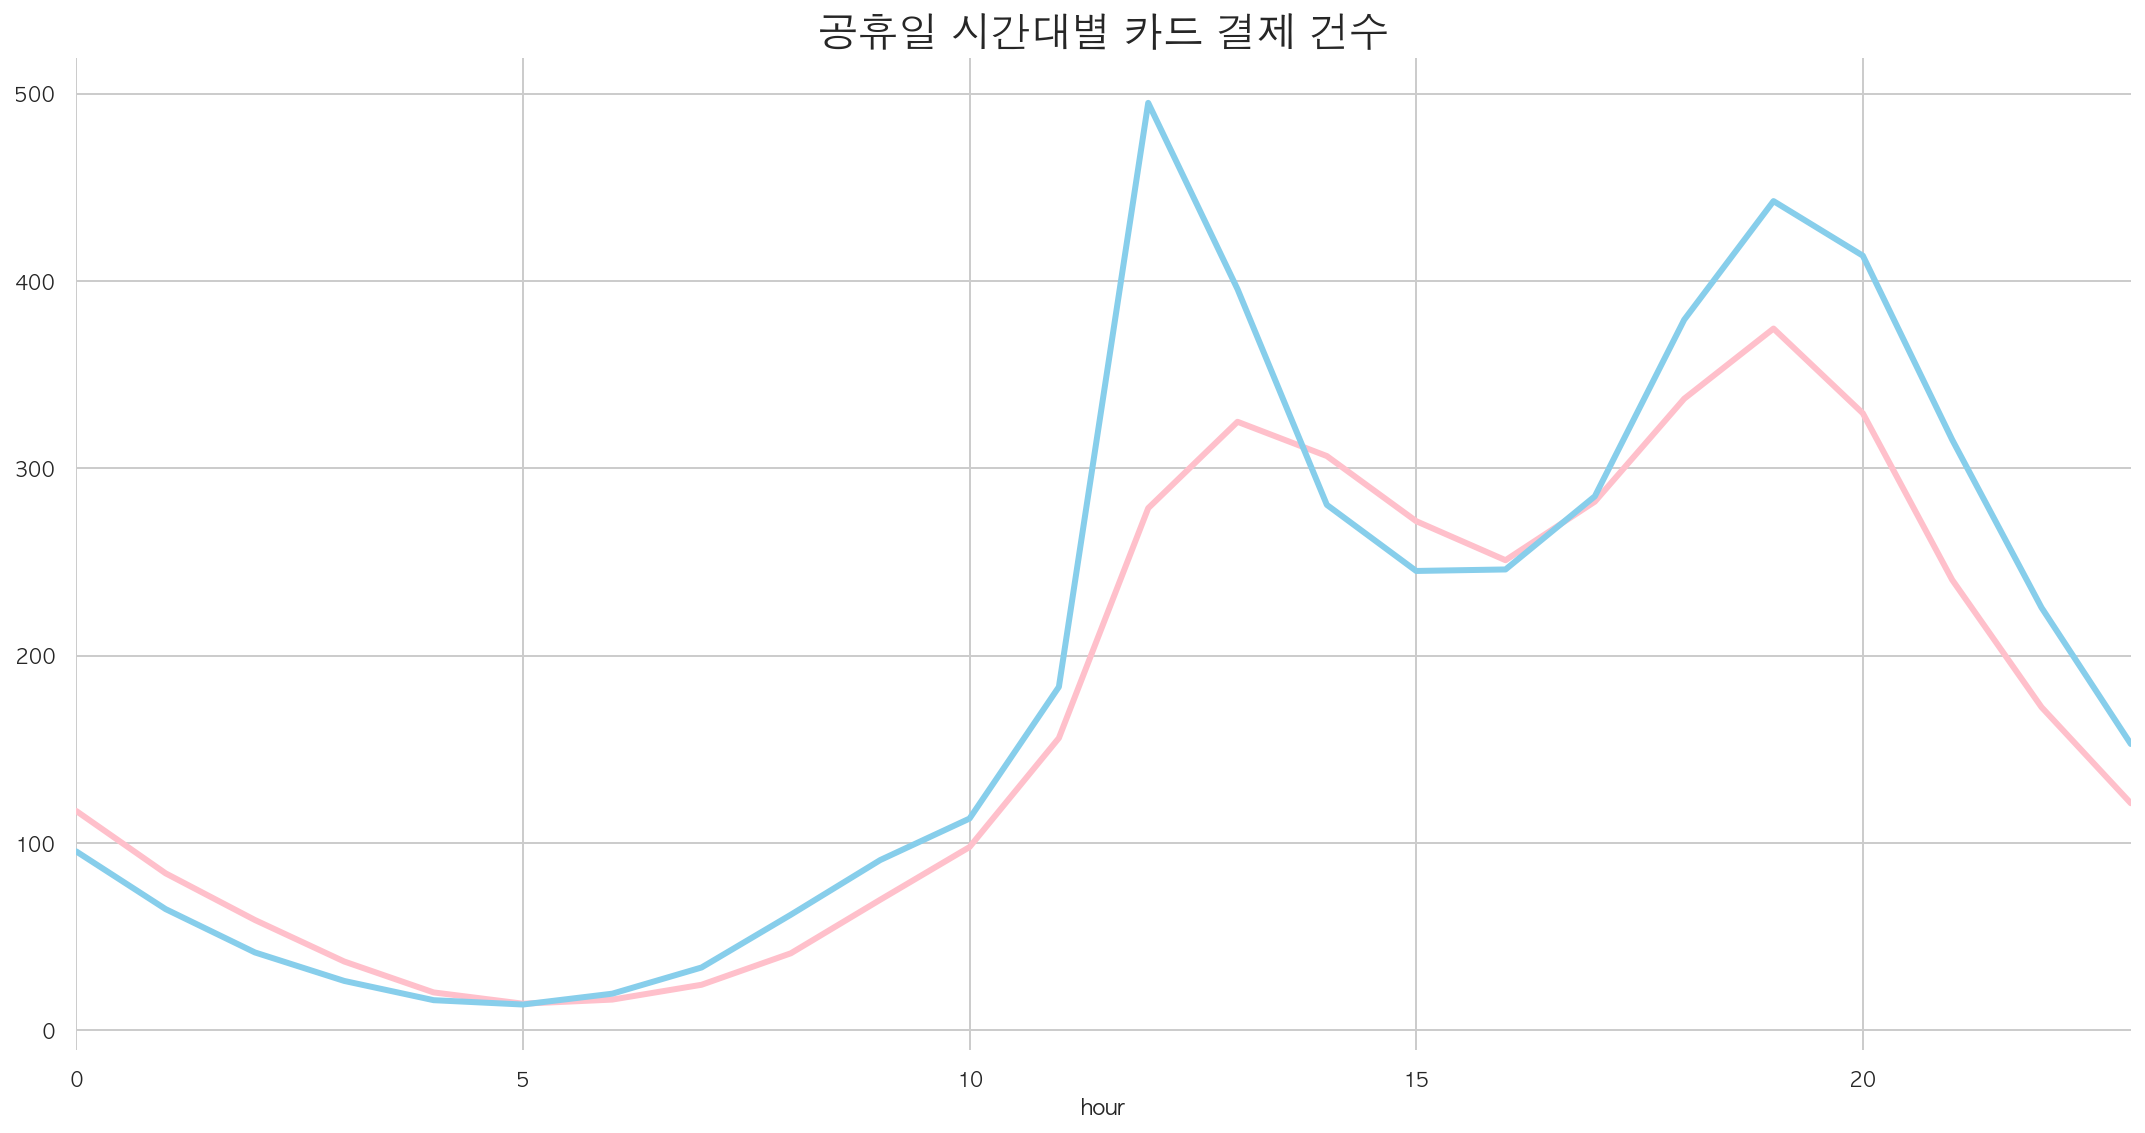

In [492]:
df7 = df_holy.groupby('hour')['count'].sum() / 37
df8 = df_daily.groupby('hour')['count'].sum() / 693
df7.plot(linewidth = 3, color = 'pink')
df8.plot(linewidth = 3, color = 'skyblue')
plt.title("공휴일 시간대별 카드 결제 건수",fontsize = 20)

plt.tight_layout()
plt.show()

 - 새벽 시간대에 거래금액이 월등히 높은 것에 비해 거래 건수가 낮은 것을 볼 수 있다. 
 
 - 10-14시 사이, 18-22시 사이에 건수가 큰폭으로 상승하는 것을 볼 수 있다. 
 
 - 식사시간에 많은 인원이 결제를 하지만 그 금액은 크지 않다.

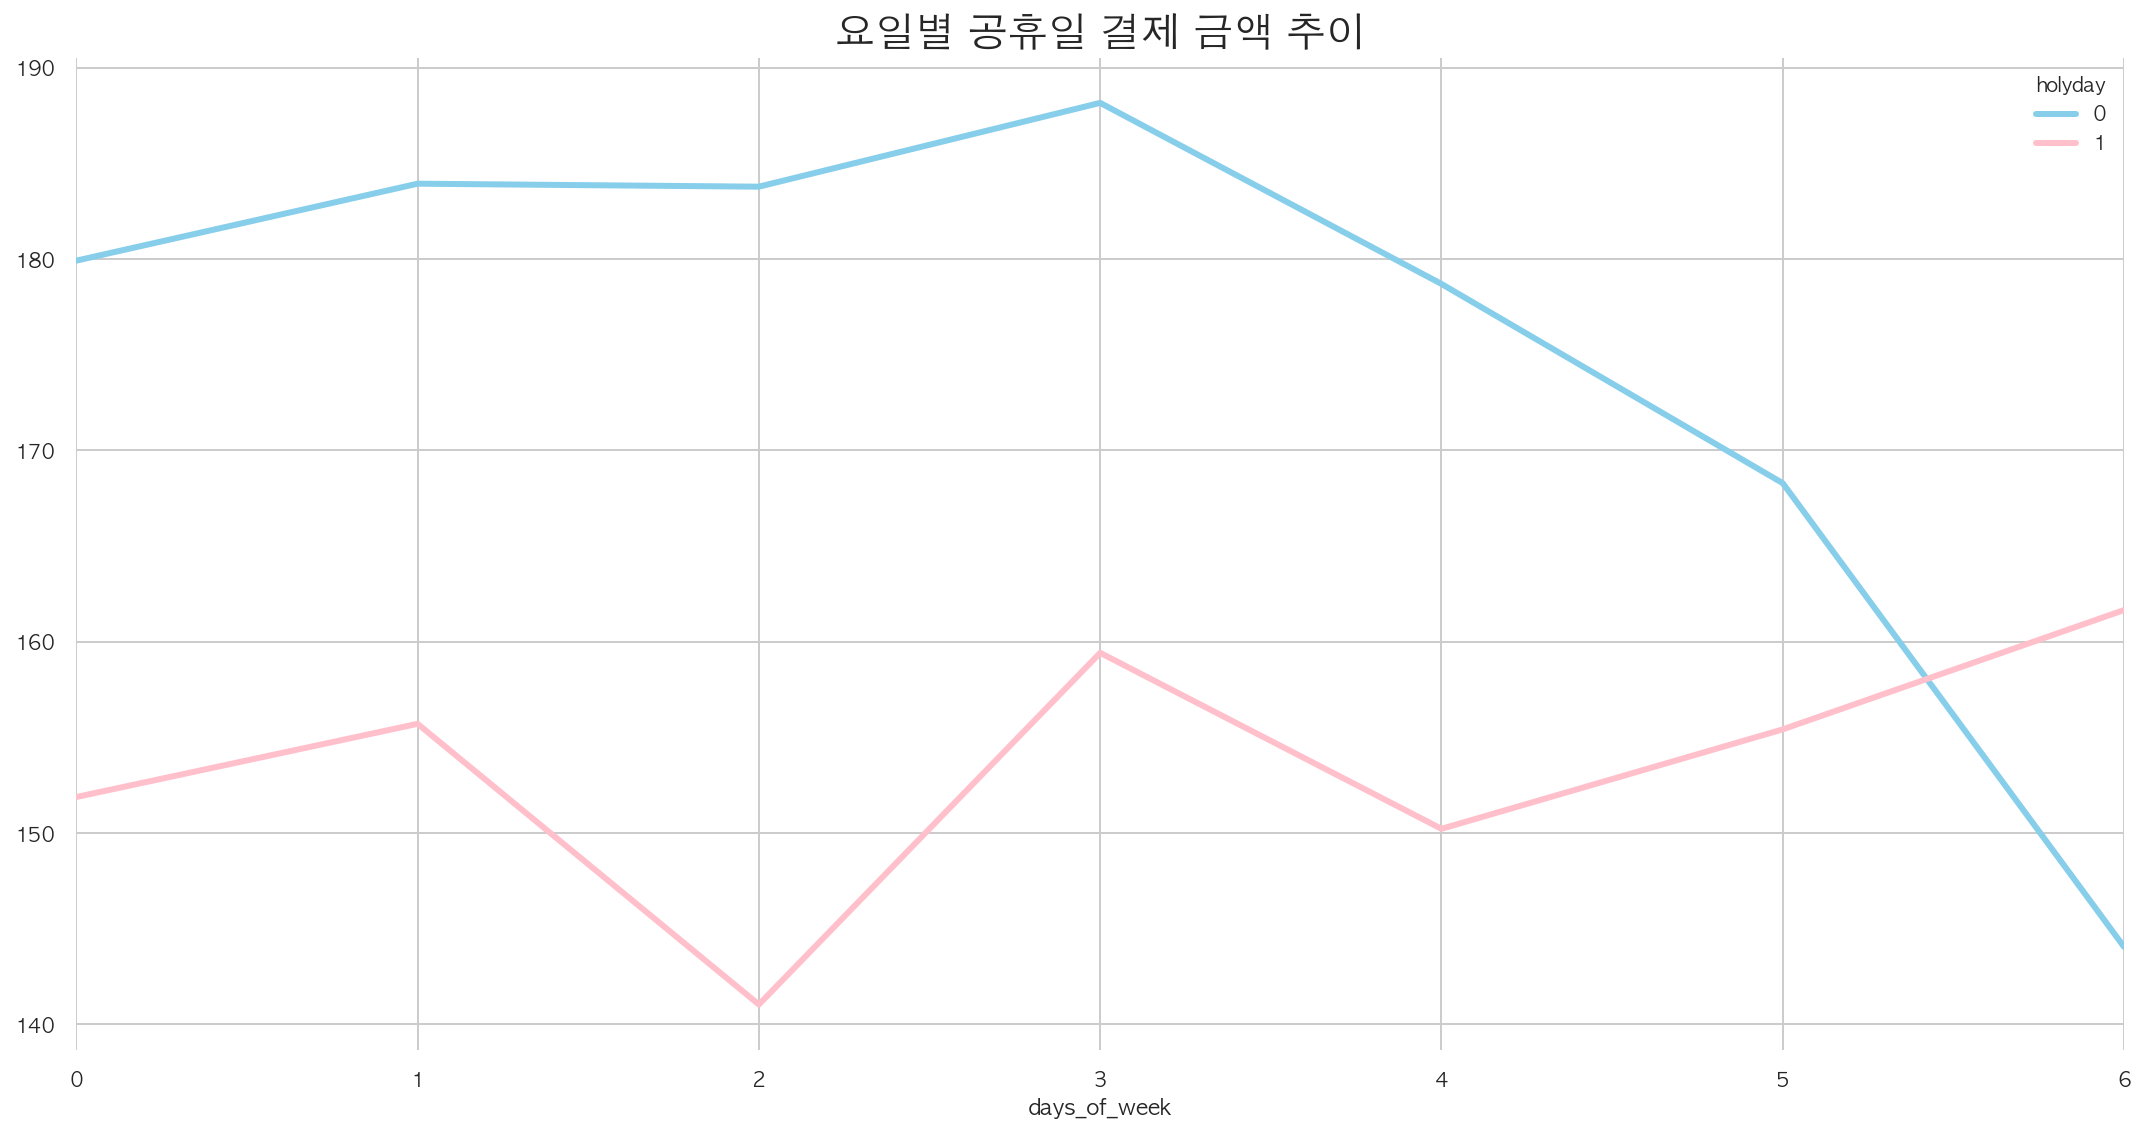

In [485]:
dt_holy = train.pivot_table('total','days_of_week','holyday',aggfunc= 'mean')
dt_holy.plot(linewidth = 3,color = ['skyblue','pink'])
plt.title("요일별 공휴일 결제 금액 추이",fontsize = 20)
plt.tight_layout()
plt.show()

 - 휴일이면서 주말인 날에 거래 금액이 증가하는 것을 볼 수 있다. 
 - 주말이 공휴일인 날은 대체 휴무로 인한 휴일의 연장 가능성이 있기 때문에 소비의 증가로 이어지는 것으로 보인다

In [405]:
# 공휴일
dt3 = df_holy.groupby('date').agg({'holyday':'mean'})
dt3.count()

holyday    37
dtype: int64

In [471]:
df3 = df_week.groupby('hour')['total'].median()
df4 = df_weekend.groupby('hour')['total'].median()

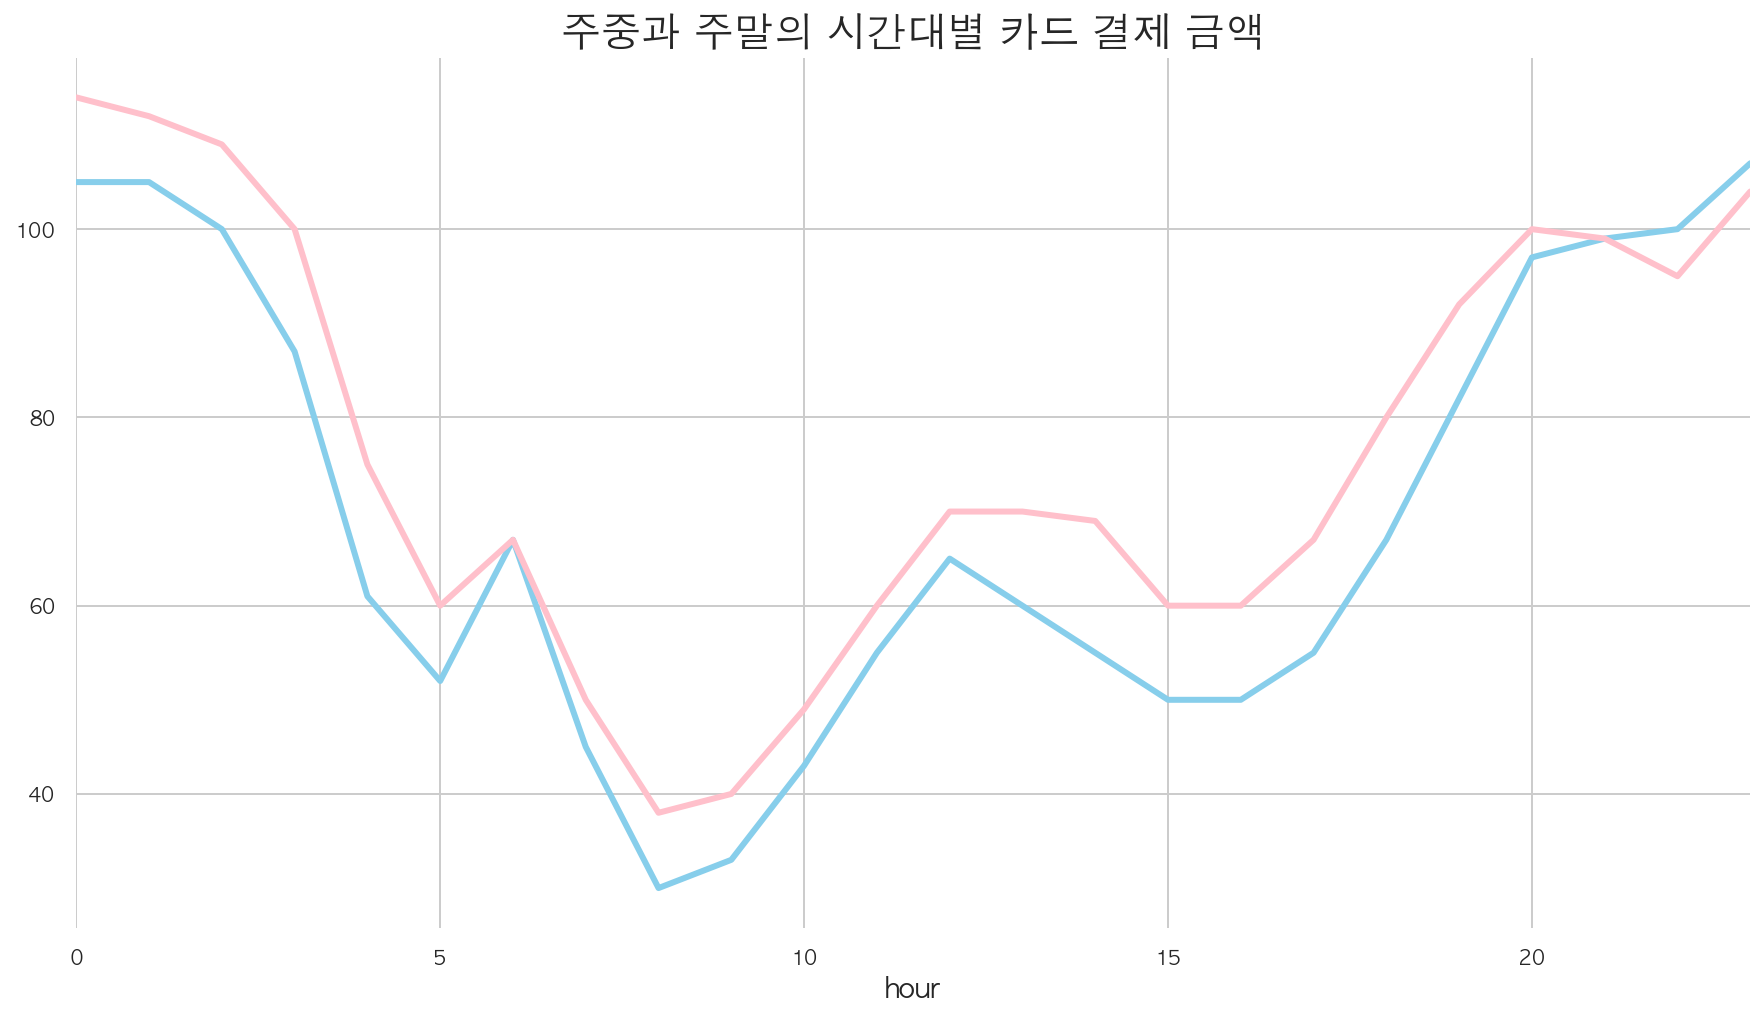

In [472]:
df3.plot(linewidth = 3, color = 'skyblue')
df4.plot(linewidth = 3, color = 'pink')
plt.xlabel('hour',fontsize = 14)
# plt.ylabel("amount",fontsize = 14)
plt.title("주중과 주말의 시간대별 카드 결제 금액",fontsize = 20)
plt.show()

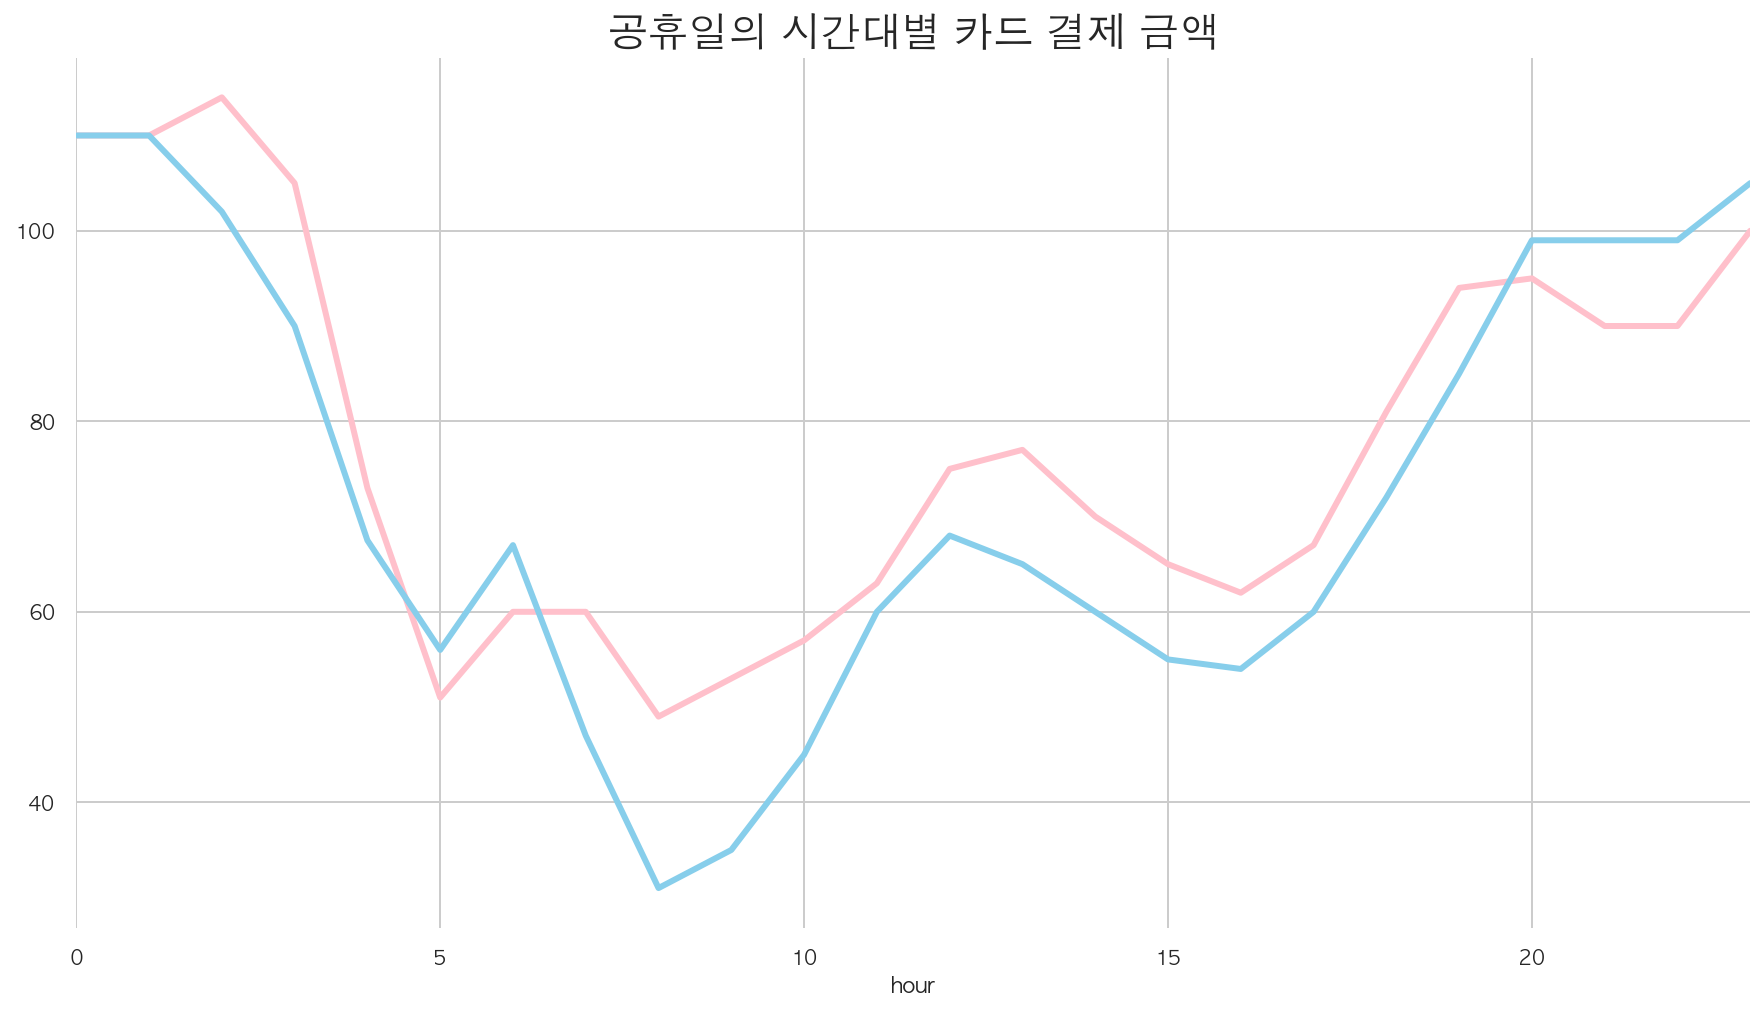

In [473]:
df5 = df_holy.groupby('hour')['total'].median()
df6 = df_daily.groupby('hour')['total'].median()
df5.plot(linewidth = 3, color = 'pink')
df6.plot(linewidth = 3, color = 'skyblue')
plt.title("공휴일의 시간대별 카드 결제 금액",fontsize = 20)

plt.show()

 - 공휴일의 그래프는 위에 있는 평일/주말의 그래프와 거의 비슷한 양상을 보이고 있다. 
 - 평일에 비해 공휴일이나 주말 결제 금액이 높은 것을 알 수 있었다. 